# Data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
catalog = pd.read_csv('data/data_catalogue.csv')
data = pd.read_csv('data/data_arena_members.csv')

In [125]:
def plot_hist2d(x,
                y,
                title,
                xlabel,
                ylabel,
                ax,
                bins=(50,50),
                cmap=plt.cm.BuPu):
    ax.hist2d(x, y, bins=bins, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def price_ditributions(catalog,
                       price='creds'):
    if not price in ['creds', 'gold']:
        raise ValueError('Can display only creds and gold distibutions!')
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,30))
    for i, ax in enumerate(axs.flat):
        ax.set_title(f'Level {i + 1}')
        sns.distplot(catalog[catalog['item_level']==i+1]['item_price_credit' if price=='creds' else 'item_price_gold'].values,
                     kde=i!=0 and i!=9, bins=15, ax=ax)
    plt.show()
    
def get_regression_line(x,
                        y,
                        degree):
    params = np.polyfit(x, y, degree)
    poly = np.poly1d(params)
    x_grid = np.linspace(min(x), max(x), 100)
    y_grid = poly(x_grid)
    return x_grid, y_grid

def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[len(features)]),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    loss = tf.keras.losses.MSE

    model.compile(loss=loss,
                  optimizer=optimizer)
    return model

def plot_history(models):
    k = len(models)
    
    fig, axs = plt.subplots(nrows=(k+1)//2, ncols=2, figsize=(16,30))
    
    for i, ax in enumerate(axs.flat):
        if i >= k:
            break
        
        history = models[i][1]
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch
    
        ax.set_title(f'Model {i+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        
        ax.plot(hist['epoch'], hist['loss'], label='Train loss')
        ax.plot(hist['epoch'], hist['val_loss'], label='Val loss')
        
        ax.set_ylim([0,1])
        ax.legend()

    plt.show()
    
def get_mean_mse(models):
    total_loss = 0
    for model in models:
        total_loss += model[2]
    return total_loss / len(models)

def get_best_model(models):
    min_loss, ind = float('inf'), -1
    for i, model in enumerate(models):
        if model[2] < min_loss:
            min_loss = model[2]
            ind = i
    return models[ind][0]

# Cleaning catalog

In [4]:
removed_tanks = pd.DataFrame()

masks = [
    ('cleaning by crew_size: 2 <= crew_size <= 6', \
    (catalog['crew_size'] >= 2) & (catalog['crew_size'] <= 6)),
    
    ('cleaning by 1 level: item_price_credit = item_price_gold = 0', \
    (catalog['item_level'] != 1) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0))),
    
    ('cleaning by price: item_price_credit > 100 or item_price_gold > 100', \
    (catalog['item_level'] == 1) | \
    (((catalog['item_price_credit'] > 100) & (catalog['item_price_gold'] == 0)) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] > 100)))),
    
    ('custom cleaning by price 2 level: 2000 < item_price_credit < 20000', \
    (catalog['item_level'] != 2) | (catalog['item_price_gold'] != 0) | \
    (catalog['item_price_credit'] > 2000) & (catalog['item_price_credit'] < 20000)),
    
    ('custom cleaning by price 5 level: item_price_credit < 500000', \
    (catalog['item_level'] != 5) | \
    (catalog['item_price_gold'] != 0) | (catalog['item_price_credit'] < 500000))
]

for mask in masks:
    N = len(catalog)
    
    removed_tanks = pd.concat([removed_tanks, catalog.loc[~mask[1]]])
    catalog = catalog.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(catalog)} rows.')
    
catalog.index = np.arange(len(catalog))
removed_tanks.index = np.arange(len(removed_tanks))

print(f'\nTotally removed {len(removed_tanks)} rows.')

[CLEANING BY CREW_SIZE: 2 <= CREW_SIZE <= 6]: removed 7 rows.
[CLEANING BY 1 LEVEL: ITEM_PRICE_CREDIT = ITEM_PRICE_GOLD = 0]: removed 9 rows.
[CLEANING BY PRICE: ITEM_PRICE_CREDIT > 100 OR ITEM_PRICE_GOLD > 100]: removed 98 rows.
[CUSTOM CLEANING BY PRICE 2 LEVEL: 2000 < ITEM_PRICE_CREDIT < 20000]: removed 20 rows.
[CUSTOM CLEANING BY PRICE 5 LEVEL: ITEM_PRICE_CREDIT < 500000]: removed 1 rows.

Totally removed 135 rows.


In [5]:
removed_tanks

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,46145,lightTank,0,0,10,1
1,46353,heavyTank,0,0,10,1
2,57857,mediumTank,0,1,1,1
3,59921,SPG,0,0,1,0
4,65025,lightTank,0,0,1,1
...,...,...,...,...,...,...
130,42753,mediumTank,915000,0,2,5
131,42769,lightTank,500,0,2,3
132,43009,lightTank,38500,0,2,3
133,43265,lightTank,39300,0,2,2


In [6]:
classEncoder = LabelEncoder()

catalog['item_class'] = classEncoder.fit_transform(catalog['item_class'])
catalog

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,1,4,356700,0,5,4
1,17,4,373000,0,5,5
2,33,2,0,1500,5,5
3,49,4,0,7500,8,4
4,81,4,0,0,1,5
...,...,...,...,...,...,...
748,64817,3,0,3500,6,5
749,65041,1,0,0,1,6
750,65073,2,0,12250,8,4
751,65297,2,0,12500,8,5


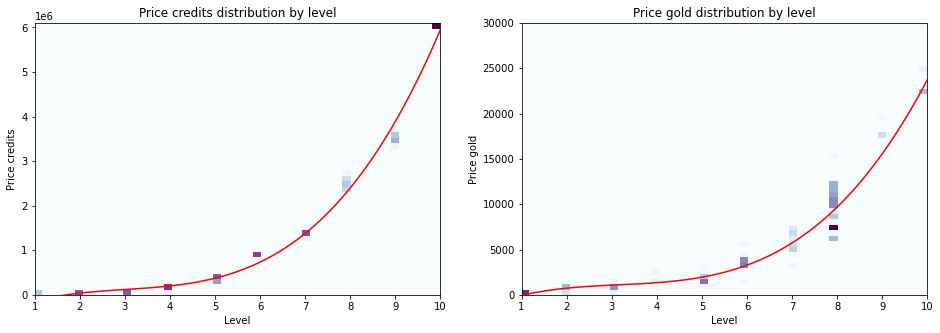

In [7]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

degree = 3
prices = creds_catalog[['item_level', 'item_price_credit']].values

plot_hist2d(x=creds_catalog['item_level'],
            y=creds_catalog['item_price_credit'],
            title='Price credits distribution by level',
            xlabel='Level',
            ylabel='Price credits',
            ax=axs[0])
axs[0].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

degree = 3
prices = gold_catalog[['item_level', 'item_price_gold']].values

plot_hist2d(x=gold_catalog['item_level'],
            y=gold_catalog['item_price_gold'],
            title='Price gold distribution by level',
            xlabel='Level',
            ylabel='Price gold',
            ax=axs[1])
axs[1].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

plt.show()

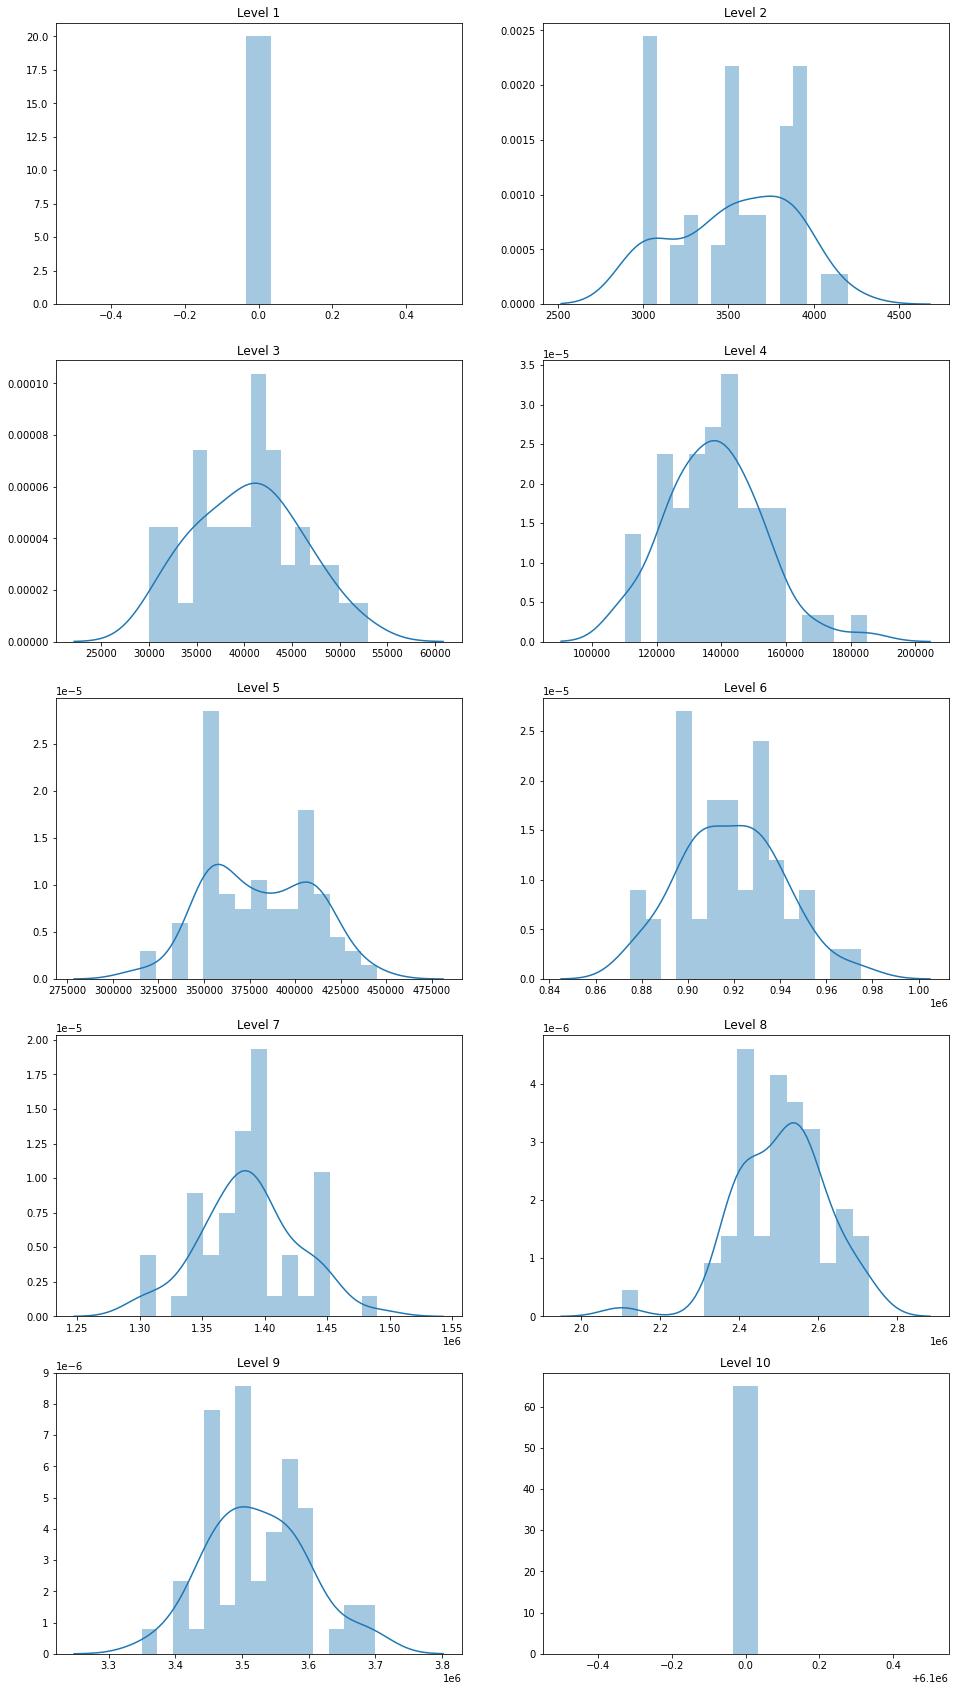

In [8]:
price_ditributions(creds_catalog, price='creds')

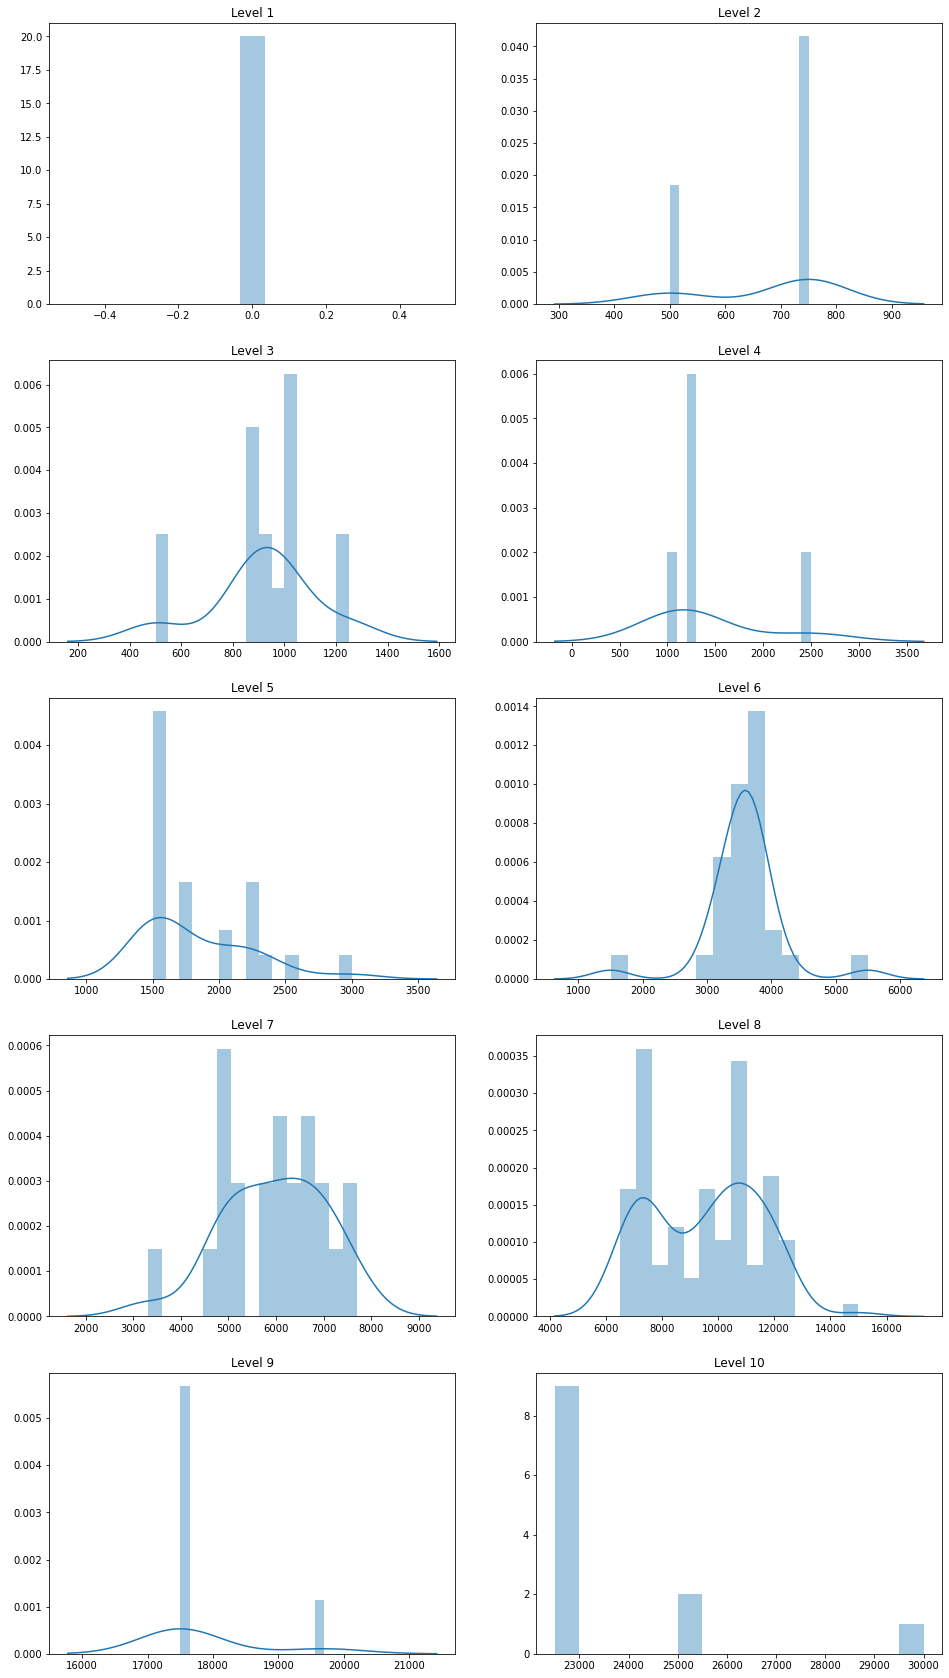

In [9]:
price_ditributions(gold_catalog, price='gold')

In [10]:
catalog.shape

(753, 6)

In [11]:
catalog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 753 entries, 0 to 752
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   item_cd            753 non-null    int64
 1   item_class         753 non-null    int32
 2   item_price_credit  753 non-null    int64
 3   item_price_gold    753 non-null    int64
 4   item_level         753 non-null    int64
 5   crew_size          753 non-null    int64
dtypes: int32(1), int64(5)
memory usage: 38.2 KB


In [12]:
catalog.describe()

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
count,753.000000,753.000000,7.530000e+02,753.000000,753.000000,753.000000
mean,23770.243028,2.386454,1.168060e+06,2238.698539,6.175299,4.290837
std,22300.034277,1.459808,1.844741e+06,4594.101058,2.525103,0.964328
min,1.000000,0.000000,0.000000e+00,0.000000,1.000000,2.000000
25%,4993.000000,1.000000,0.000000e+00,0.000000,4.000000,4.000000
50%,14625.000000,3.000000,1.400000e+05,0.000000,6.000000,4.000000
75%,49937.000000,4.000000,1.400000e+06,1500.000000,8.000000,5.000000
max,65345.000000,4.000000,6.100000e+06,30000.000000,10.000000,6.000000


In [13]:
# --> no duplicates
catalog.duplicated().sum()

0

In [14]:
# --> no missing values
catalog.isnull().sum()

item_cd              0
item_class           0
item_price_credit    0
item_price_gold      0
item_level           0
crew_size            0
dtype: int64

#  Looking on removed tanks

In [15]:
s1 = set(removed_tanks['item_cd'])
s2 = set(data['vehicle_type_cd'])

removed_ids = s1.intersection(s2)

print(removed_ids)

{6225, 13889, 9297, 65281}


In [16]:
removed_tanks[removed_tanks['item_cd'] == 9297]

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
18,9297,AT-SPG,0,5,10,5


In [17]:
data[data['vehicle_type_cd'] == 9297]

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
259,2018-10-27,4yNy1TNaa7yd71T4c,cdcyd44Ta,2,500019571,0,0,9297,365,5,...,1226,0,22046,384,15,10,34065,1270,0,0
3252,2018-10-17,424y7TyaNcyyT4cTy,cyNy71y2c,2,500135958,0,0,9297,415,5,...,1117,0,34650,622,15,10,41198,1400,0,201
3269,2018-10-17,424y7TyaNcyyT4cTy,c2yyN4a22,1,500040230,0,0,9297,477,9,...,1339,1330,104877,4430,15,20,22696,1140,34959,869
3498,2018-10-17,424y12T24Ny22TTTa,cyyT1T4cN,1,500159862,0,0,9297,656,8,...,2342,874,52922,1646,15,10,51289,0,0,0
3653,2018-10-17,424y7yd21cddc7cdd,c2yTNddca,2,500069934,0,0,9297,323,3,...,1267,2000,18123,1488,15,20,38614,390,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377598,2018-10-17,21cN2N1TydaT1dc27,cdyc7TddN,1,500012667,0,0,9297,356,6,...,1181,1237,38034,2189,15,20,66027,390,0,0
1383488,2018-10-17,24Ndc74a7NcyTTTNN,ca2adcNd2,2,500004709,0,0,9297,281,3,...,528,0,25070,412,15,10,33198,240,8357,0
1386077,2018-10-26,12ac27ycN147ad7,cdaa1TTdy,2,0,0,0,9297,433,1,...,1512,370,11817,2368,15,40,45529,400,0,469
1394142,2018-10-17,a2adaNdTcTTNd1Naa,cdacaT4Tc,2,500156864,0,0,9297,290,4,...,797,1713,24936,891,15,10,29711,0,0,0


# Visualizing catalog

In [18]:
for feature in ['item_cd']:
    catalog[feature] = pd.Categorical(catalog[feature])

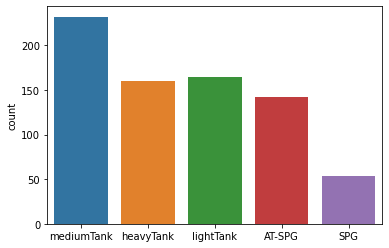

In [19]:
sns.countplot(classEncoder.inverse_transform(catalog['item_class']));

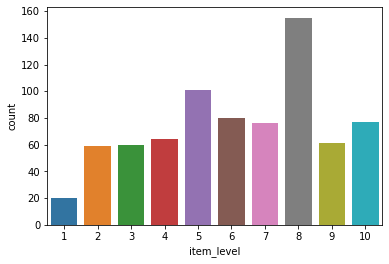

In [20]:
sns.countplot(catalog['item_level']);

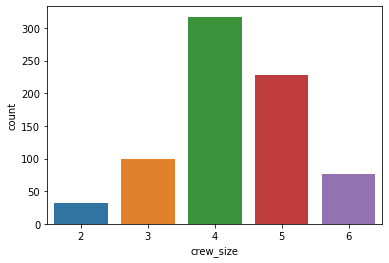

In [21]:
sns.countplot(catalog['crew_size']);

# Cleaning data

In [22]:
data.head()

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
0,2018-10-27,4yNy14y4yN12d42dT,c42c4aydT,2,0,0,0,2849,132,3,...,459,-3,27279,1084,15,20,11956,0,0,0
1,2018-10-27,4yNy14y4yN12d42dT,c2TaaayN4,1,500033550,0,0,63553,195,6,...,708,0,6282,68,15,10,9832,0,0,0
2,2018-10-27,4yNy14y4yN12d42dT,cyyd47dc4,2,500051107,67896661,0,17665,224,11,...,656,0,36102,3560,15,20,39190,0,0,1130
3,2018-10-27,4yNy14y4yN12d42dT,c2cdc441y,2,0,0,0,11537,381,8,...,1912,387,16317,1678,15,20,7217,0,0,0
4,2018-10-27,4yNy14y4yN12d42dT,cdT7cTT21,1,0,0,0,7937,198,5,...,507,0,11620,232,15,10,9532,0,0,0


In [23]:
mask = ~data['vehicle_type_cd'].isin(removed_ids)

removed_data = data.loc[~mask]
data = data.loc[mask]

data.reset_index()
removed_data.reset_index();

### arena_id

47.363 unique battles were held.

There were 30 players in most battles (30 -> 20 -> 14). 
However, in some battles, a number of players was either odd (19, 13) or 
strangely small (2, 4). Are those battles connected to special events?

In [29]:
battles = data['arena_id'].value_counts()
battles

yyyyd1d41y77yN4      30
4T4yy272yyydTa2da    30
4T4yy2241TT42c1ya    30
4T4yy21d7ddN127Tc    30
4T4yy21N2NdNyN7dd    30
                     ..
71a1daddT4yN4c7       5
424y1a22T2d7T11a7     4
Ty72acc1444a4d1       3
Ty7cc77dTNNd7N4       3
4d2721ay1a7c11Nya     2
Name: arena_id, Length: 47363, dtype: int64

In [24]:
# --> no duplicates
data.duplicated().sum()

0

In [25]:
#  --> no null values
data.isnull().sum()

dt                          0
arena_id                    0
account_db_id               0
team_id                     0
clan_db_id                  0
prebattle_id                0
is_prebattle_creator        0
vehicle_type_cd             0
life_time_sec               0
shots                       0
hits                        0
he_hits                     0
pierced                     0
damage_dealt                0
damage_assisted_radio       0
damage_assisted_stun        0
damage_assisted_track       0
damage_received             0
shots_received              0
no_damage_shots_received    0
pierced_received            0
spotted                     0
damaged                     0
kills_made                  0
mileage_meter               0
remained_hp                 0
original_credits            0
original_xp                 0
premium_xp_factor           0
daily_xp_factor             0
battle_num                  0
damage_blocked_by_armor     0
booster_bonus_credits       0
booster_bo

In [26]:
data.describe()

,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,hits,he_hits,pierced,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
count,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,...,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06
mean,1.500015e+00,2.843357e+08,7.294752e+06,7.079043e-02,2.386333e+04,2.976125e+02,7.738088e+00,5.339142e+00,3.320121e-01,3.643013e+00,...,1.172246e+03,1.897758e+02,3.101764e+04,1.051120e+03,1.499911e+01,1.358995e+01,2.330440e+04,4.412997e+02,2.002091e+03,1.087956e+02
std,5.000002e-01,2.476789e+08,2.682752e+07,2.564745e-01,2.240353e+04,1.348247e+02,5.083874e+00,4.033766e+00,1.314188e+00,3.004952e+00,...,7.146780e+02,3.943647e+02,2.388215e+04,1.048548e+03,1.153706e-01,7.431287e+00,1.681411e+04,7.220207e+02,7.046242e+03,2.797172e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.900000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-1.300000e+01,-1.037000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.501000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.377000e+03,2.010000e+02,4.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,...,6.920000e+02,0.000000e+00,1.472100e+04,3.300000e+02,1.500000e+01,1.000000e+01,1.052100e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,5.000197e+08,0.000000e+00,0.000000e+00,1.334500e+04,2.870000e+02,7.000000e+00,5.000000e+00,0.000000e+00,3.000000e+00,...,1.027000e+03,0.000000e+00,2.421600e+04,6.900000e+02,1.500000e+01,1.000000e+01,1.931200e+04,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+00,5.000720e+08,0.000000e+00,0.000000e+00,5.019300e+04,3.740000e+02,1.000000e+01,7.000000e+00,0.000000e+00,5.000000e+00,...,1.507000e+03,1.180000e+02,3.972800e+04,1.418000e+03,1.500000e+01,2.000000e+01,3.192300e+04,6.400000e+02,0.000000e+00,0.000000e+00
max,2.000000e+00,5.001649e+08,2.687535e+08,1.000000e+00,6.507300e+04,9.000000e+02,6.300000e+01,5.100000e+01,2.700000e+01,4.000000e+01,...,1.491800e+04,3.000000e+03,3.055860e+05,1.341000e+04,1.500000e+01,4.000000e+01,2.210440e+05,1.665000e+04,1.577200e+05,3.274000e+03


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1402958 entries, 0 to 1403404
Data columns (total 34 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   dt                        1402958 non-null  object
 1   arena_id                  1402958 non-null  object
 2   account_db_id             1402958 non-null  object
 3   team_id                   1402958 non-null  int64 
 4   clan_db_id                1402958 non-null  int64 
 5   prebattle_id              1402958 non-null  int64 
 6   is_prebattle_creator      1402958 non-null  int64 
 7   vehicle_type_cd           1402958 non-null  int64 
 8   life_time_sec             1402958 non-null  int64 
 9   shots                     1402958 non-null  int64 
 10  hits                      1402958 non-null  int64 
 11  he_hits                   1402958 non-null  int64 
 12  pierced                   1402958 non-null  int64 
 13  damage_dealt              1402958 non-null

# Visualizing data

In [28]:
for feature in ['arena_id', 'account_db_id', 'team_id', 'clan_db_id', 
               'prebattle_id', 'is_prebattle_creator', 'vehicle_type_cd']:
    data[feature] = pd.Categorical(data[feature])
    
data['dt'] = pd.to_datetime(data['dt'])

## dt

All battles took place in October 2018 (between October 1 and October 31)

In [29]:
data['dt'].describe()

count                 1402958
unique                     31
top       2018-10-10 00:00:00
freq                    90939
first     2018-10-01 00:00:00
last      2018-10-31 00:00:00
Name: dt, dtype: object

## arena_id

47.363 unique battles were held.

There were 30 players in most battles (30 -> 20 -> 14). 
However, in some battles, a number of players was either odd (19, 13) or 
strangely small (2, 4). Are those battles connected to special events?

In [30]:
battles = data['arena_id'].value_counts()
battles

yyyyd1d41y77yN4      30
4TNN1T2TdT12d7y7a    30
4TNN1T1TyN77TNadc    30
4TNN1Nya1ayd274N2    30
4TNN1Ny1y2cNTcTaN    30
                     ..
424y1a22T2d7T11a7     4
71a1daddT4yN4c7       4
Ty7cc77dTNNd7N4       3
Ty72acc1444a4d1       3
4d2721ay1a7c11Nya     2
Name: arena_id, Length: 47363, dtype: int64

In [31]:
battles.to_frame()['arena_id'].value_counts()

30    45479
20     1033
14      417
29      373
28       26
19        8
27        5
13        5
12        4
18        3
3         2
4         2
6         1
17        1
7         1
21        1
24        1
2         1
Name: arena_id, dtype: int64

## account_db_id

367.746 unique players took part in battles.

In [32]:
data['account_db_id'].value_counts()

c2aTcT4y4    214
cdNcaNN77    201
c277NNN2y    140
cadaaNc77    121
c4NacTcc4     98
            ... 
cdN1a12cT      1
cdN1Ty4y2      1
cdN1Ty212      1
cdN1Tdc1y      1
c2111224a      1
Name: account_db_id, Length: 367685, dtype: int64

## team_id

Either 1 or 2

In [33]:
data['team_id'].value_counts()

2    701500
1    701458
Name: team_id, dtype: int64

## prebattle_id, is_prebattle_creator

~83% of players were not a part of any platoon

In [34]:
data[data['prebattle_id'] == 0].shape[0] / data.shape[0]

0.8267403585852178

In [35]:
data['is_prebattle_creator'].value_counts()

0    1303642
1      99316
Name: is_prebattle_creator, dtype: int64

## vehicle_type_cd

All tanks used in the battles are real (there is a corresponding entry in "catalog")

In [36]:
data['vehicle_type_cd'].describe()

count     1402958
unique        347
top         50193
freq        77041
Name: vehicle_type_cd, dtype: int64

In [37]:
data['vehicle_type_cd'].unique().isin(catalog['item_cd']).sum()

347

## Different battle characteristics

Need to be normalized to lifetime in a battle / mileage meter

In [38]:
target_params = ['shots', 'hits', 'he_hits', 'pierced']
damage_params = ['damage_dealt', 'damage_assisted_track', 'damage_assisted_radio', 
               'damage_assisted_stun']
income_params = ['damage_received', 'shots_received', 'no_damage_shots_received',
                'pierced_received']

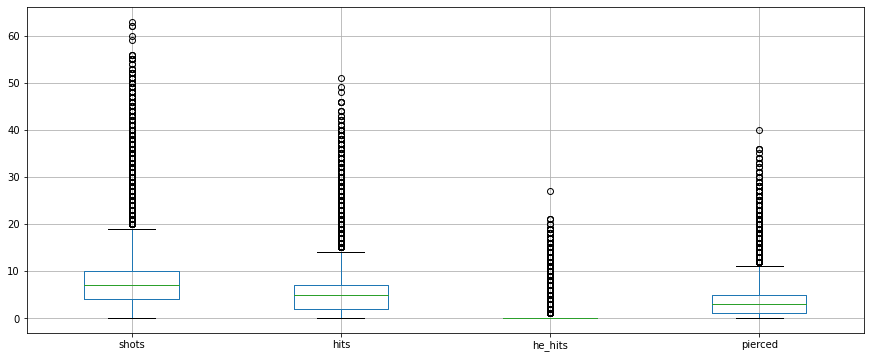

In [39]:
data[target_params].boxplot(figsize=(15, 6));

In [40]:
data[target_params].corr()

,shots,hits,he_hits,pierced
shots,1.000000,0.889603,0.042677,0.793255
hits,0.889603,1.000000,-0.164152,0.882728
he_hits,0.042677,-0.164152,1.000000,-0.090797
pierced,0.793255,0.882728,-0.090797,1.000000


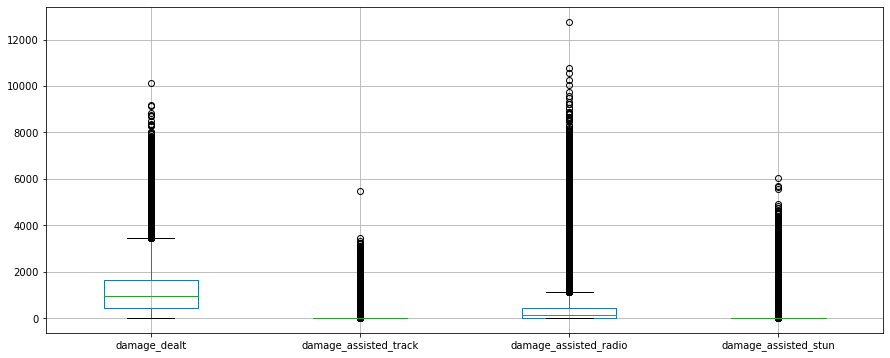

In [41]:
data[damage_params].boxplot(figsize=(15, 6));

In [42]:
data[damage_params].corr()

,damage_dealt,damage_assisted_track,damage_assisted_radio,damage_assisted_stun
damage_dealt,1.000000,0.162962,0.083276,0.052412
damage_assisted_track,0.162962,1.000000,0.032367,-0.020921
damage_assisted_radio,0.083276,0.032367,1.000000,-0.112713
damage_assisted_stun,0.052412,-0.020921,-0.112713,1.000000


In [43]:
data[income_params].describe()

,damage_received,shots_received,no_damage_shots_received,pierced_received
count,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06
mean,1.162548e+03,5.298307e+00,1.668547e+00,3.629759e+00
std,5.268389e+02,3.593638e+00,2.452998e+00,1.881117e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+02,3.000000e+00,0.000000e+00,2.000000e+00
50%,1.300000e+03,5.000000e+00,1.000000e+00,4.000000e+00
75%,1.500000e+03,7.000000e+00,2.000000e+00,5.000000e+00
max,3.000000e+03,6.700000e+01,6.200000e+01,2.000000e+01


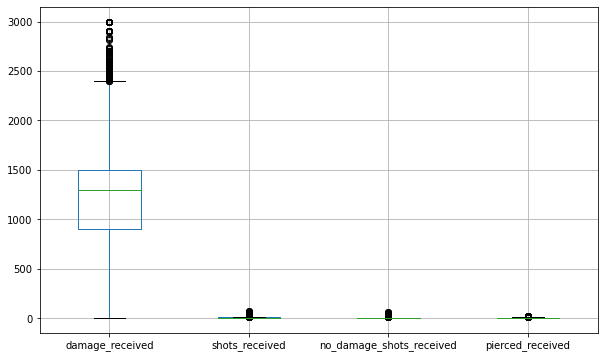

In [44]:
data[income_params].boxplot(figsize=(10, 6));

## life_time_sec

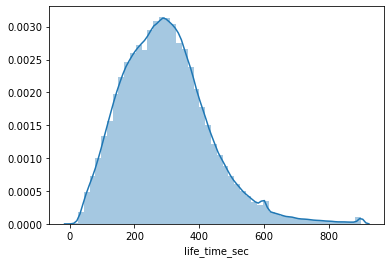

In [45]:
sns.distplot(data['life_time_sec']);

# Create new features (normalized to time/etc) 

In [46]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0
    
normalize_feature = np.vectorize(normalize_feature)

## Normalize to time

In [47]:
target_features = ['shots', 'hits', 'he_hits', 'pierced', 'damage_dealt', 
                   'damage_assisted_track', 'damage_assisted_radio', 
                   'damage_assisted_stun', 'damage_received', 'shots_received', 
                   'no_damage_shots_received', 'pierced_received', 'spotted', 
                   'damaged', 'kills_made', 'mileage_meter']
# target_features = ['shots']

for feature in target_features:
    new_feature = feature + '_per_sec'
    data[new_feature] = normalize_feature(data[feature], data['life_time_sec'])

## Compare distributions before and after normalization

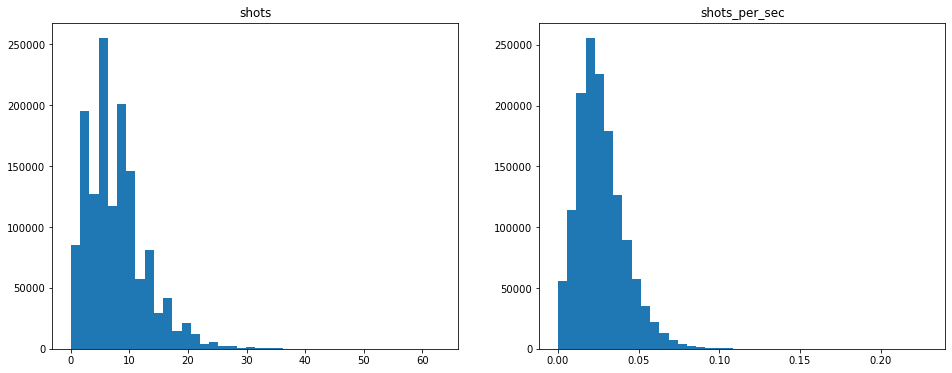

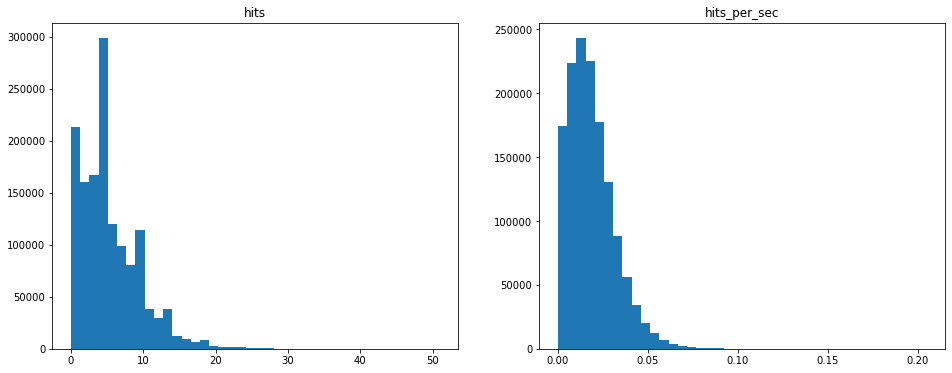

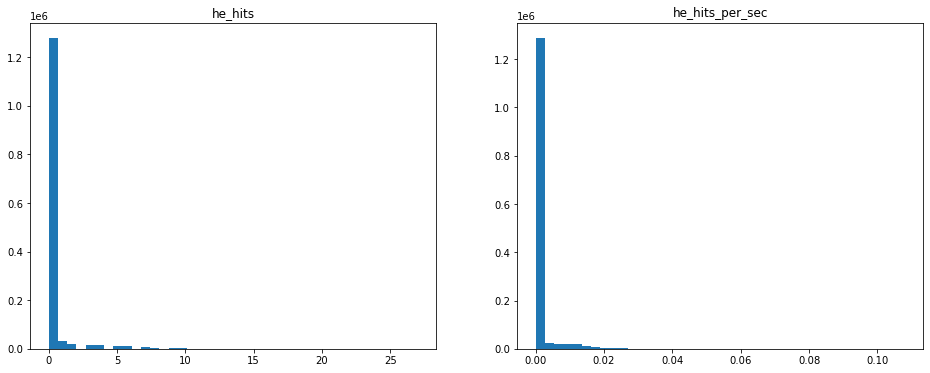

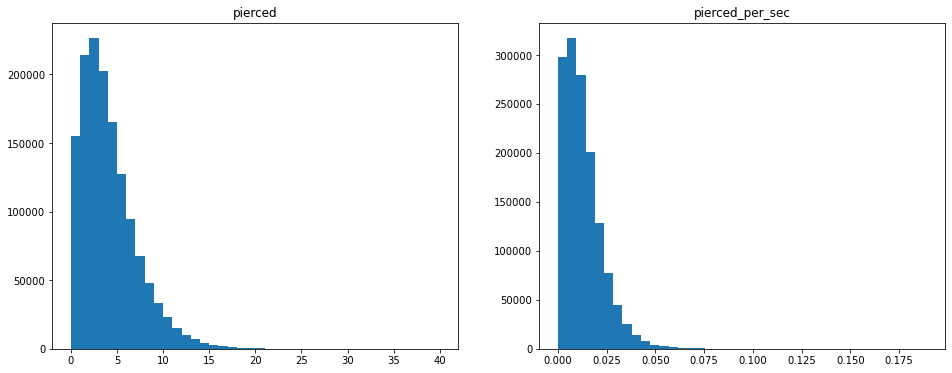

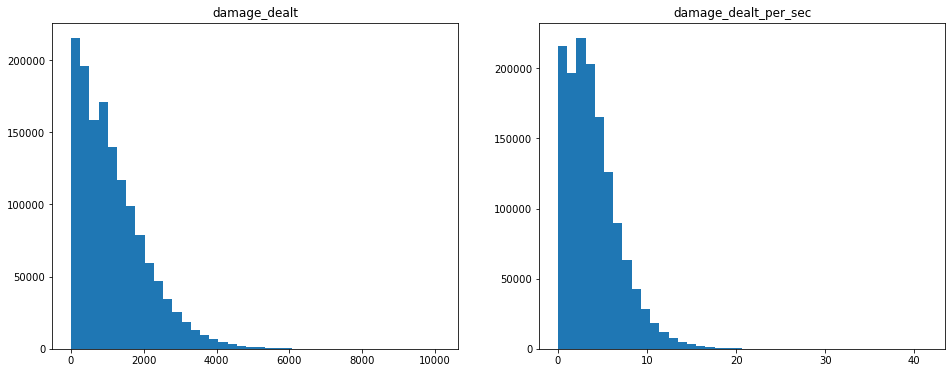

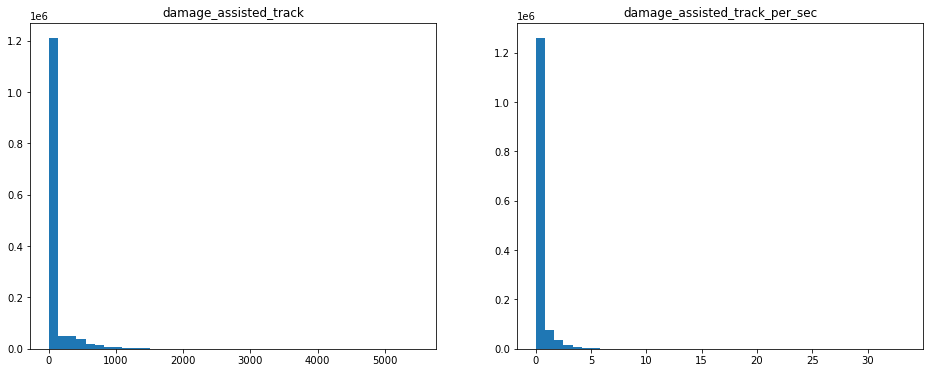

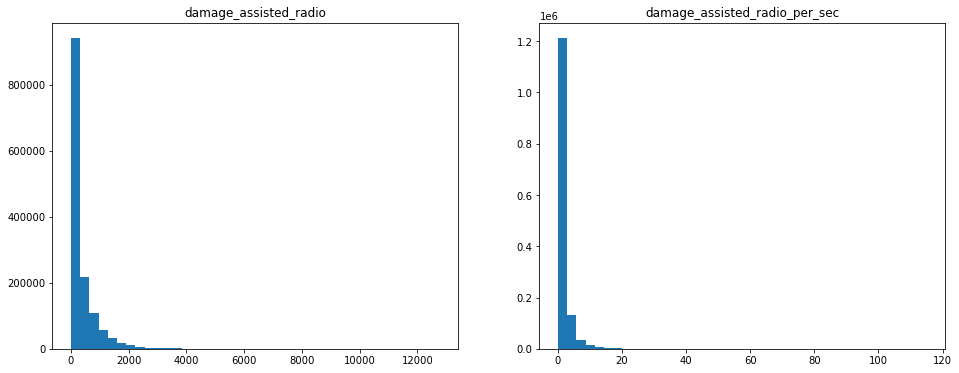

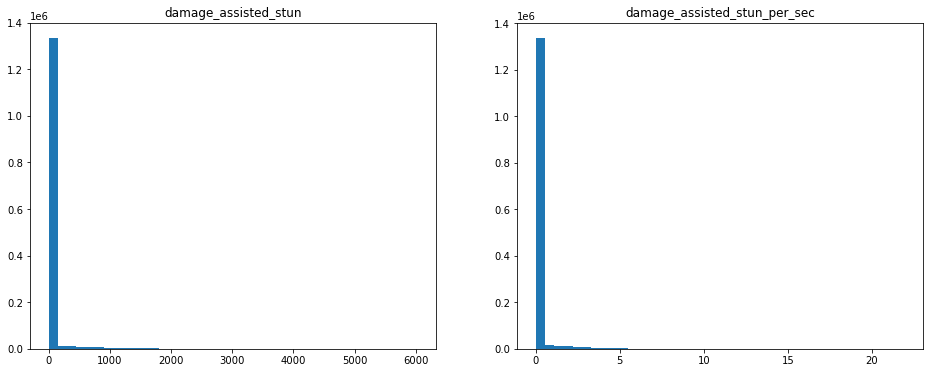

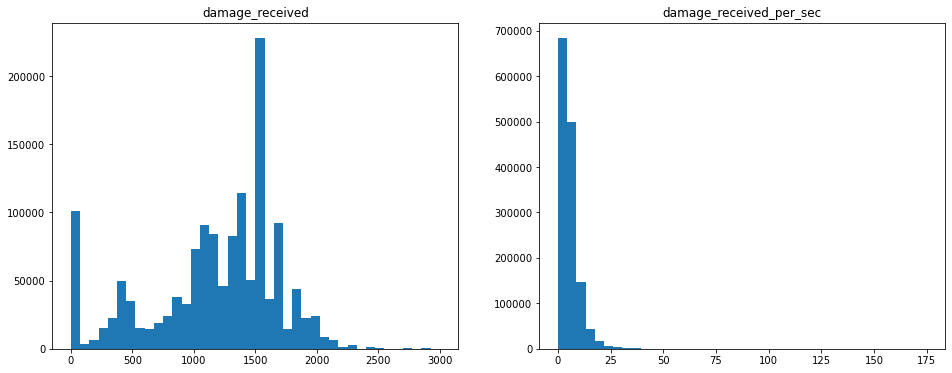

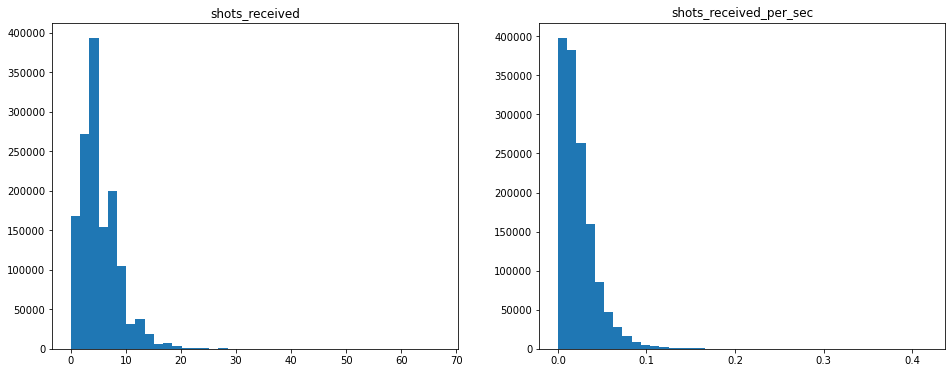

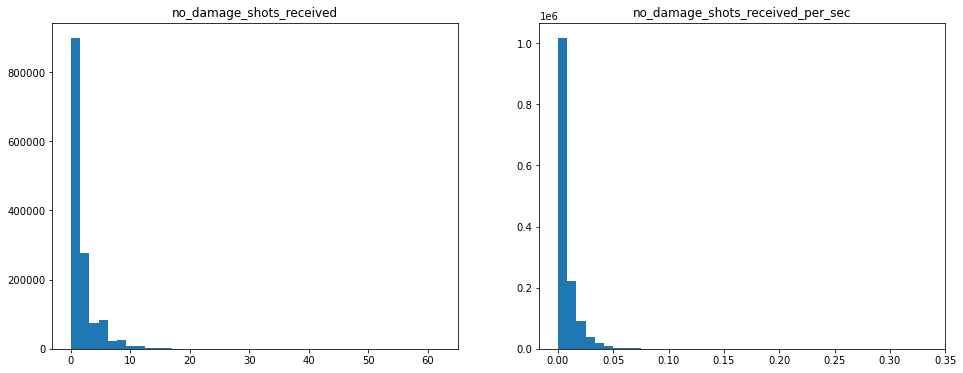

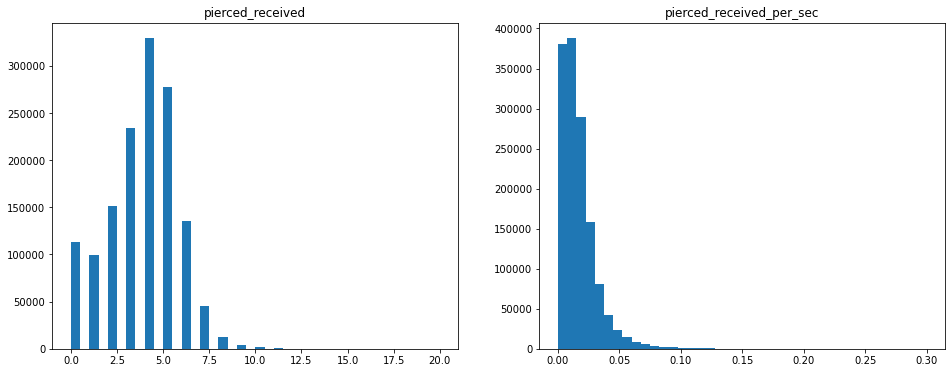

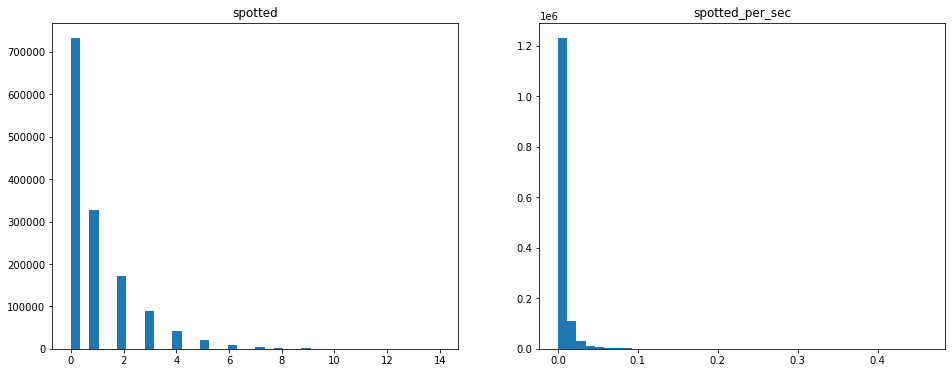

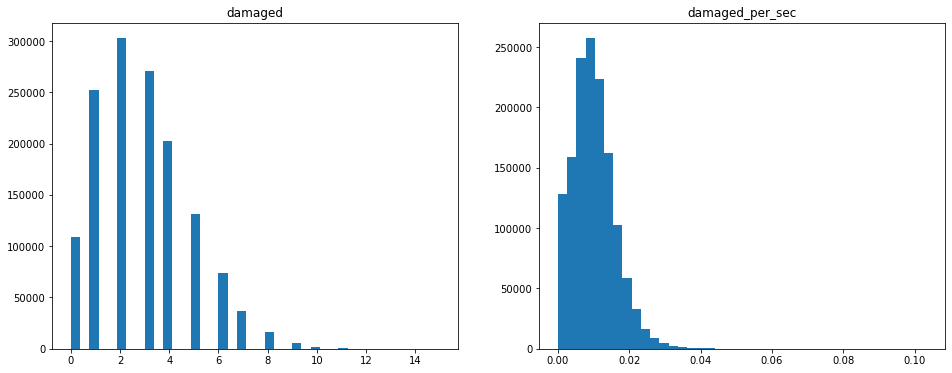

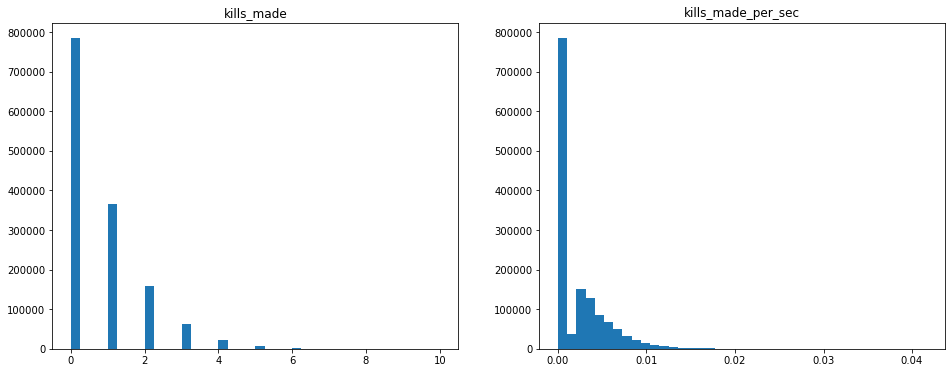

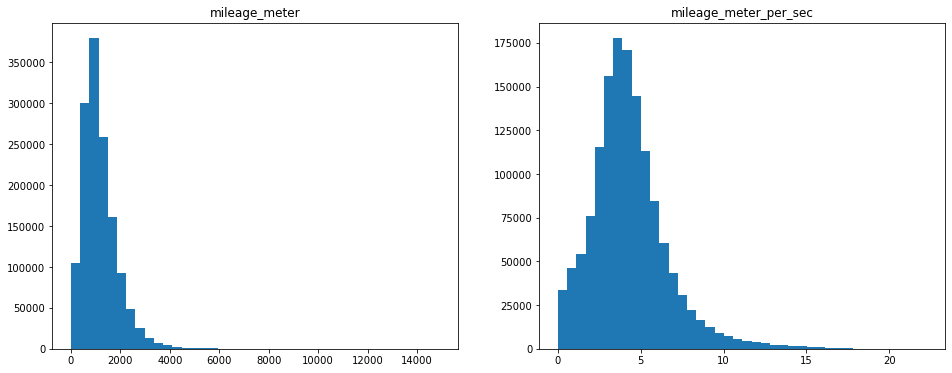

In [48]:
for feature in target_features:
    new_feature = feature + '_per_sec'

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].hist(data[feature], bins=40)
    axes[1].hist(data[new_feature], bins=40)
    
    axes[0].set_title(feature)
    axes[1].set_title(new_feature)

# Joining data

In [49]:
joined_data = data.merge(catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')
joined_data

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,spotted_per_sec,damaged_per_sec,kills_made_per_sec,mileage_meter_per_sec,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,2018-10-27,4yNy14y4yN12d42dT,c42c4aydT,2,0,0,0,2849,132,3,...,0.007576,0.015152,0.000000,3.477273,2849,2,0,12000,8,6
1,2018-10-27,4yNy14y4yN12d42dT,c2TaaayN4,1,500033550,0,0,63553,195,6,...,0.005128,0.005128,0.000000,3.630769,63553,4,0,7450,8,4
2,2018-10-27,4yNy14y4yN12d42dT,cyyd47dc4,2,500051107,67896661,0,17665,224,11,...,0.000000,0.017857,0.008929,2.928571,17665,4,3450000,0,9,4
3,2018-10-27,4yNy14y4yN12d42dT,c2cdc441y,2,0,0,0,11537,381,8,...,0.002625,0.010499,0.010499,5.018373,11537,0,2570000,0,8,5
4,2018-10-27,4yNy14y4yN12d42dT,cdT7cTT21,1,0,0,0,7937,198,5,...,0.005051,0.010101,0.005051,2.560606,7937,4,3450000,0,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402953,2018-10-11,1ccdcTcya4T7Nyc,cac4aa12N,2,500150344,5640480,0,1921,364,9,...,0.000000,0.005495,0.000000,5.936813,1921,2,2540000,0,8,3
1402954,2018-10-11,1ccdcTcya4T7Nyc,cdTcc72Nc,1,500138824,5288203,0,913,311,6,...,0.003215,0.009646,0.003215,3.620579,913,2,0,10700,8,4
1402955,2018-10-11,1ccdcTcya4T7Nyc,cd42c2TTT,1,500154303,5288203,0,50193,174,2,...,0.005747,0.005747,0.000000,2.787356,50193,0,0,10900,8,4
1402956,2018-10-11,1ccdcTcya4T7Nyc,cd4a7Tc72,2,500156478,5640480,0,51361,136,7,...,0.014706,0.029412,0.000000,5.588235,51361,4,0,11000,8,4


In [50]:
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1402958 entries, 0 to 1402957
Data columns (total 56 columns):
 #   Column                            Non-Null Count    Dtype         
---  ------                            --------------    -----         
 0   dt                                1402958 non-null  datetime64[ns]
 1   arena_id                          1402958 non-null  category      
 2   account_db_id                     1402958 non-null  category      
 3   team_id                           1402958 non-null  category      
 4   clan_db_id                        1402958 non-null  category      
 5   prebattle_id                      1402958 non-null  category      
 6   is_prebattle_creator              1402958 non-null  category      
 7   vehicle_type_cd                   1402958 non-null  int64         
 8   life_time_sec                     1402958 non-null  int64         
 9   shots                             1402958 non-null  int64         
 10  hits              

In [51]:
joined_data.drop(['item_cd'], axis=1, inplace=True)

# Correlations

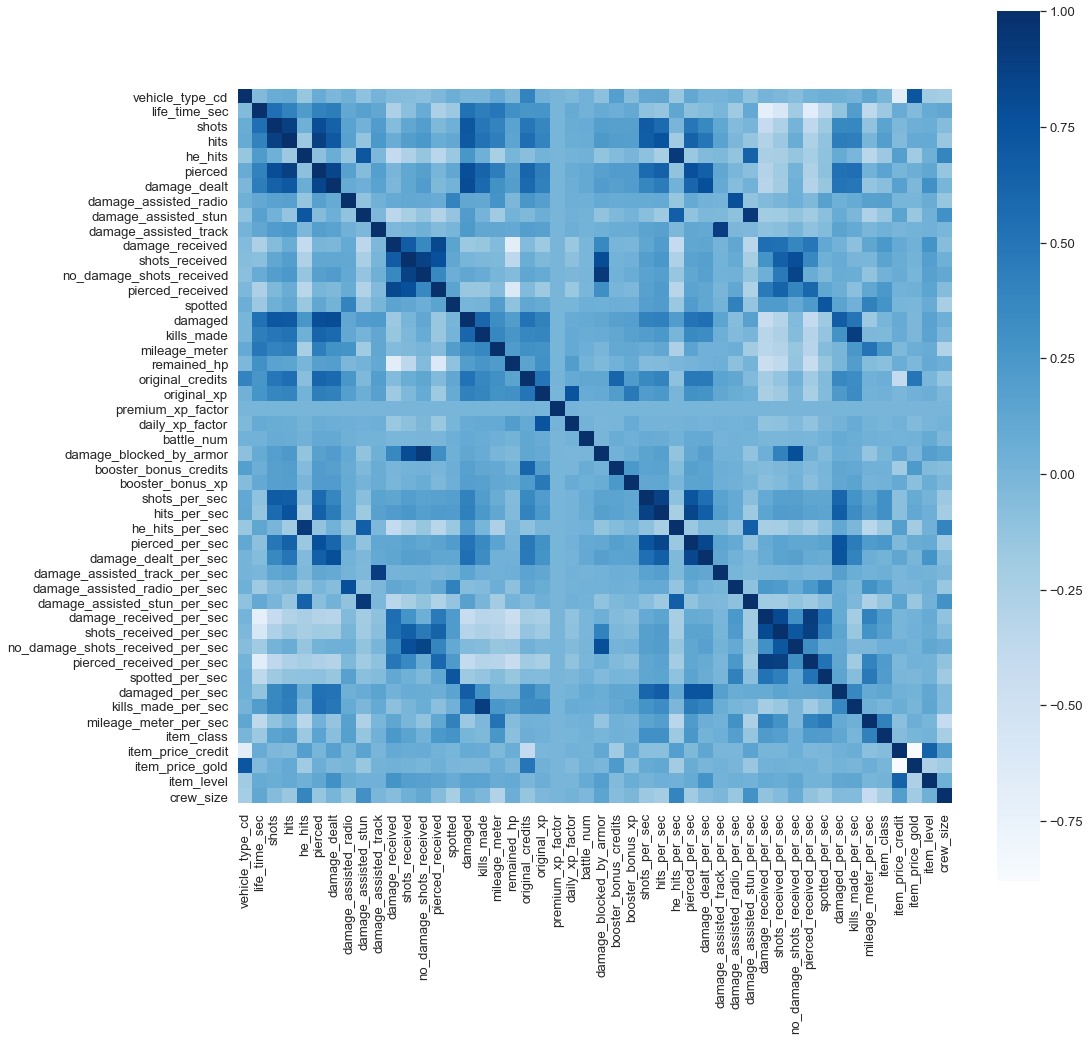

item_price_credit                  -0.879595
item_level                         -0.257673
he_hits_per_sec                    -0.197115
he_hits                            -0.191737
crew_size                          -0.190591
damage_assisted_stun               -0.150168
damage_assisted_stun_per_sec       -0.147580
booster_bonus_xp                   -0.081813
life_time_sec                      -0.039822
daily_xp_factor                    -0.037196
damage_dealt                       -0.025258
remained_hp                        -0.023619
damaged                            -0.017034
spotted_per_sec                    -0.015759
kills_made                         -0.015171
spotted                            -0.012602
damage_blocked_by_armor            -0.011887
kills_made_per_sec                 -0.003752
damage_assisted_radio_per_sec      -0.002405
premium_xp_factor                  -0.000887
damage_dealt_per_sec                0.000718
damage_assisted_radio               0.002846
no_damage_

In [52]:
sns.set(font_scale=1.2)

corr = joined_data.corr()

plt.figure(figsize=(16,16))
sns.heatmap(corr, square=True, cmap='Blues')

plt.show()

corr['item_price_gold'].sort_values()

shot_params = ['shots', 'hits', 'he_hits', 'pierced']
damage_params = ['damage_dealt', 'damage_assisted_track', 'damage_assisted_radio', 
               'damage_assisted_stun']
income_params = ['damage_received', 'shots_received', 'no_damage_shots_received',
                'pierced_received']

# Regression model

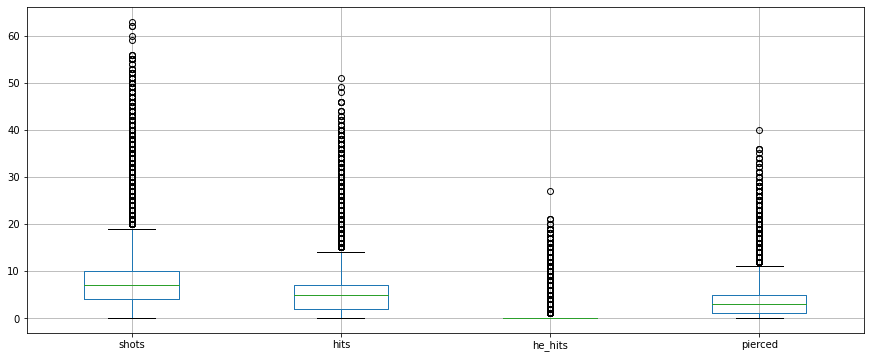

In [38]:
data[shot_params].boxplot(figsize=(15, 6));

In [39]:
data[shot_params].corr()

,item_level,item_class,damage_dealt,original_xp,original_credits,kills_made,damage_assisted_stun,he_hits,crew_size,hits,booster_bonus_credits,item_price_gold
0,8.0,4,1063.747118,1240.120084,51652.362954,0.683618,0.0,0.007707,4.0,6.970489,5386.457480,7500.0
1,6.0,4,416.653846,948.333333,20239.653846,0.371795,0.0,0.025641,5.0,5.538462,1028.179487,3650.0
3,7.0,3,637.062049,1177.643579,33906.291486,0.567100,0.0,0.005772,4.0,5.418470,2372.953824,4800.0
7,8.0,2,1047.282024,1161.835522,45384.159742,0.618945,0.0,0.090850,4.0,5.421744,4235.857696,12250.0


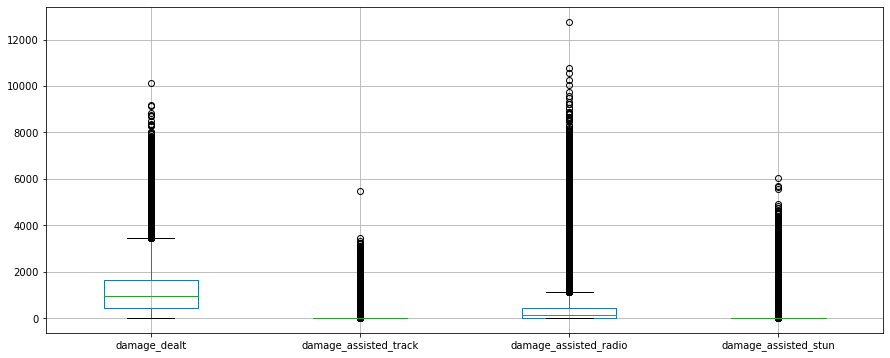

In [40]:
data[damage_params].boxplot(figsize=(15, 6));

In [44]:
res_data = joined_data.groupby('vehicle_type_cd').mean().reset_index()
res_data = res_data[res_data['vehicle_type_cd'] != 9217]

features = ['item_level', 'item_class', 'damage_dealt', 'original_xp', 'original_credits', 'kills_made', 'damage_assisted_stun', 'he_hits', 'crew_size', 'hits', 'booster_bonus_credits']
target_credit = ['item_price_credit']
target_gold = ['item_price_gold']

credit_dataset = res_data[res_data['item_price_credit'] != 0][features + target_credit]
gold_dataset = res_data[res_data['item_price_gold'] != 0][features + target_gold]

gold_dataset

7

In [112]:
data[income_params].describe()

,item_level,item_class,damage_dealt,original_xp,original_credits,kills_made,damage_assisted_stun,he_hits,crew_size,hits,booster_bonus_credits,item_price_gold
0,0.387992,0.992210,0.068357,0.547770,1.141226,-0.046843,0.0,-0.294823,-0.552158,0.422762,1.610841,-0.275670
1,-1.588919,0.992210,-1.023832,-0.854265,-1.496622,-0.941277,0.0,0.347445,0.760751,-0.250887,-0.970271,-1.098348
2,-0.600463,0.298312,-0.651819,0.247570,-0.348981,-0.381064,0.0,-0.364121,-0.552158,-0.307333,-0.173852,-0.852613
3,0.387992,-0.395587,0.040566,0.171613,0.614860,-0.232350,0.0,2.682779,-0.552158,-0.305793,0.929419,0.739321
4,0.387992,-0.395587,0.350607,0.753712,1.036430,0.044033,0.0,0.396642,-0.552158,-0.456650,1.028066,0.408113
...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.387992,0.992210,-0.412463,-0.226705,-0.031023,-0.579775,0.0,-0.220109,-0.552158,-0.404371,0.030161,-0.019251
103,0.387992,-0.395587,-0.052505,0.318496,0.590830,-0.371406,0.0,1.795755,-0.552158,-0.357671,0.542041,0.365377
104,-1.588919,-0.395587,-0.477435,-0.039401,-0.910507,-0.114588,0.0,8.024255,2.073659,-1.849577,0.092810,-0.980822
105,-1.588919,0.298312,-0.992930,-0.863257,-0.940771,-0.765950,0.0,-0.372698,0.760751,-0.232869,-0.738114,-1.130400


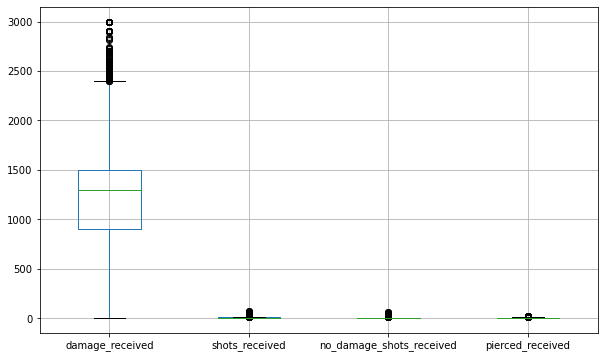

In [43]:
data[income_params].boxplot(figsize=(10, 6));

### life_time_sec

Do we need players that did not spend time in a battle at all? 
(life_time_sec = 0)

In [44]:
data[data['life_time_sec'] == 0].shape[0]

7

In [45]:
credit_scaler = StandardScaler()
gold_scaler = StandardScaler()

normed_credit_dataset = pd.DataFrame(credit_scaler.fit_transform(credit_dataset), columns=[features + target_credit])
normed_gold_dataset = pd.DataFrame(gold_scaler.fit_transform(gold_dataset), columns=[features + target_gold])

normed_gold_dataset

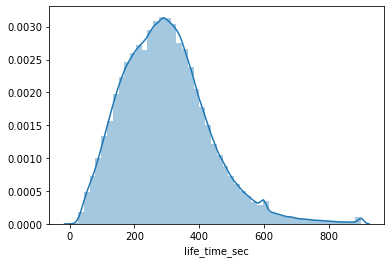

In [45]:
sns.distplot(data[data['life_time_sec'] > 0]['life_time_sec']);

### remained_hp

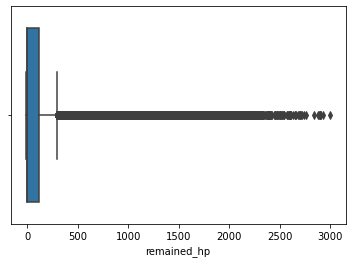

In [46]:
sns.boxplot(data['remained_hp']);

In [47]:
data_negative_hp = data[data['remained_hp'] < 0]
data_negative_hp.shape[0]

116746

### damage_dealt (total, assisted, etc.)

In [48]:
data['total_damage_dealt'] = data['damage_dealt'] + data['damage_assisted_radio'] + \
    data['damage_assisted_stun'] + data['damage_assisted_track']

In [113]:
train_data, train_labels = np.array(normed_gold_dataset[features]), np.array(normed_gold_dataset[target_gold])

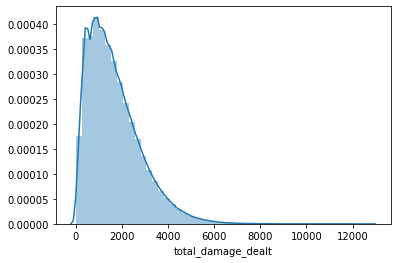

In [49]:
sns.distplot(data[data['total_damage_dealt'] > 0]['total_damage_dealt']);

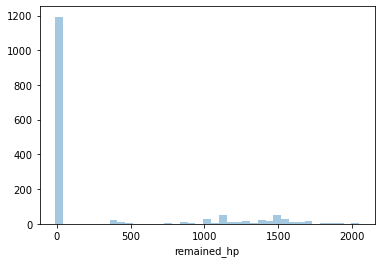

In [50]:
sns.distplot(data[(data['mileage_meter'] == 0) & (data['total_damage_dealt'] == 0)]['remained_hp'], kde=False);

In [51]:
(data[(data['mileage_meter'] == 0) & (data['total_damage_dealt'] == 0)]['damage_blocked_by_armor'] == 0).sum()

1226

### original_credits, original_xp, booster_bonus_xp, booster_bonus_credits

There is one player with original_credits < 0.

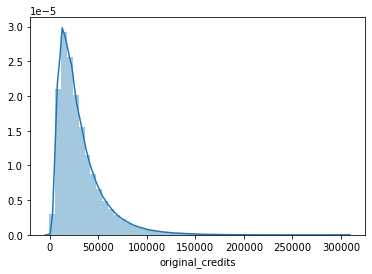

In [52]:
sns.distplot(data['original_credits']);

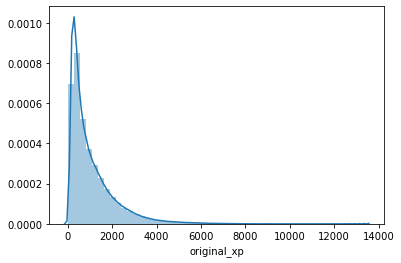

In [53]:
sns.distplot(data['original_xp']);

In [54]:
data[data['original_credits'] < 0]

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,total_damage_dealt
683724,2018-10-23,yT1Ny1yc1c77dc17T,cyN1N4Td4,1,500147675,31578326,0,5377,231,3,...,0,-1037,194,15,10,57279,0,0,0,81


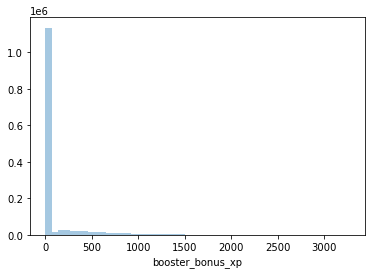

In [55]:
sns.distplot(data['booster_bonus_xp'], kde=False);

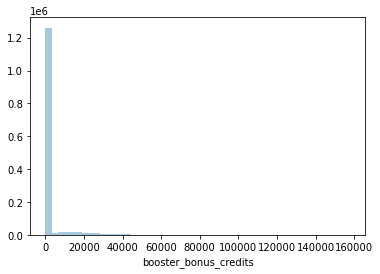

In [56]:
sns.distplot(data['booster_bonus_credits'], kde=False);

### original_xp, premium_xp_factor, daily_xp_factor, battle_num, etc.

There are 566 players that do not have a premium account

In [57]:
data['premium_xp_factor'].value_counts()

15    1403322
0          83
Name: premium_xp_factor, dtype: int64

In [58]:
data['daily_xp_factor'].value_counts()

10    1050024
20     277977
40      75321
0          83
Name: daily_xp_factor, dtype: int64

In [59]:
data['battle_num'].value_counts()

11048    84
6806     77
5935     76
3280     74
14655    74
         ..
96932     1
84642     1
88736     1
60054     1
88617     1
Name: battle_num, Length: 83343, dtype: int64

In [60]:
data[data['premium_xp_factor'] == 0]['arena_id'].isin(data[data['daily_xp_factor'] == 0]['arena_id']).sum()

83

In [61]:
data[data['original_xp'] == 0]['account_db_id'].values.unique()

[cayy4Ny4c, c4aN4y4T2, cc2Tcdyya, cyy1y7Td2, c2c2Nd111, ..., cdaTaNaad, c4427N22T, cd1744yTc, cd2N41cd2, c4ad1Nc22]
Length: 566
Categories (566, object): [cayy4Ny4c, c4aN4y4T2, cc2Tcdyya, cyy1y7Td2, ..., c4427N22T, cd1744yTc, cd2N41cd2, c4ad1Nc22]

### damage_blocked_by_armor

count    1.403405e+06
mean     4.413510e+02
std      7.220232e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.400000e+02
max      1.665000e+04
Name: damage_blocked_by_armor, dtype: float64

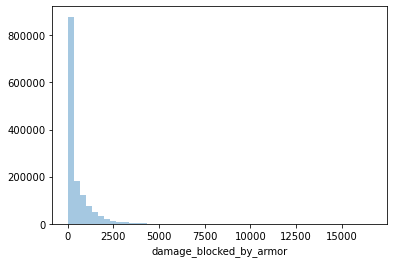

In [62]:
sns.distplot(data['damage_blocked_by_armor'], kde=False);
data['damage_blocked_by_armor'].describe()

## Create new features (normalized to time/etc) 

In [63]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0
    
normalize_feature = np.vectorize(normalize_feature)

### Calculate additive features

In [64]:
data['total_damage_dealt'] = data['damage_dealt'] + data['damage_assisted_radio'] + \
    data['damage_assisted_stun'] + data['damage_assisted_track']

data['damage_shots_received'] = data['shots_received'] - data['no_damage_shots_received']

Turns out that data['damage_shots_received'] = data['pierced_received'], so this feature is not added.

### Normalize to time

In [65]:
target_features = ['shots', 'hits', 'he_hits', 'pierced', 'damage_dealt', 
                   'damage_assisted_track', 'damage_assisted_radio', 
                   'damage_assisted_stun', 'total_damage_dealt',
                   'damage_received', 'shots_received', 
                   'pierced_received', 'spotted', 
                   'damaged', 'kills_made', 'mileage_meter',
                   'damage_blocked_by_armor']
# target_features_normalized_sec = [feature + '_per_sec' for feature in target_features]
target_features_normalized_min = [feature + '_per_min' for feature in target_features]

In [66]:
data['life_time_min'] = data['life_time_sec'] / 60

for feature in target_features:
#     data[feature + '_per_sec'] = normalize_feature(data[feature], data['life_time_sec'])
    data[feature + '_per_min'] = normalize_feature(data[feature], data['life_time_min'])

### Compare distributions before and after normalization

#### Normalized to life_time_min

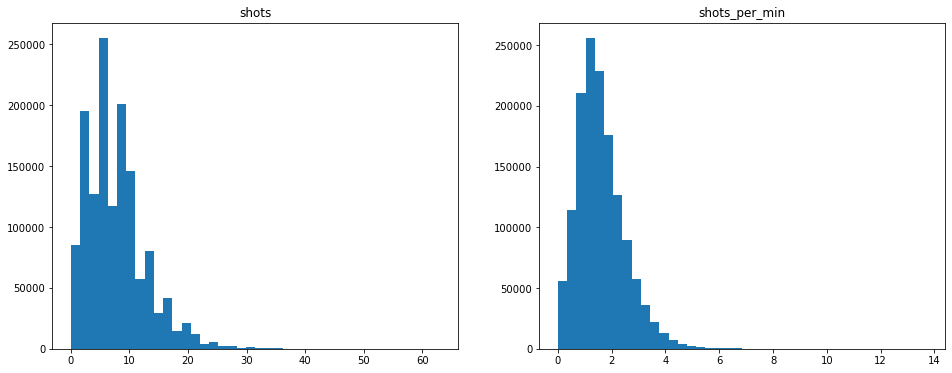

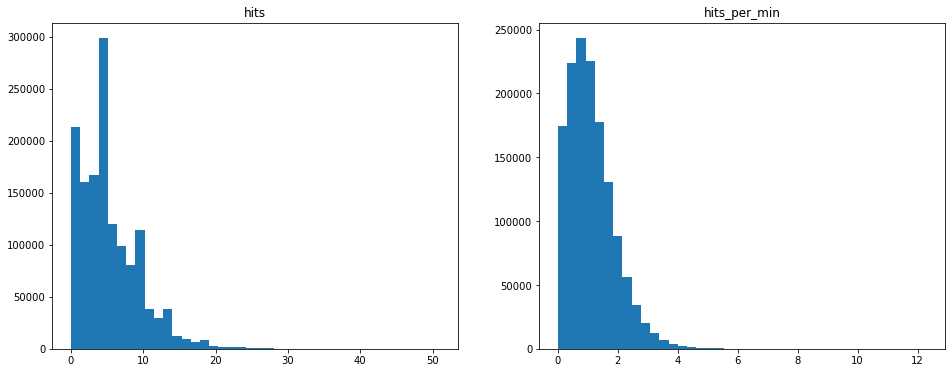

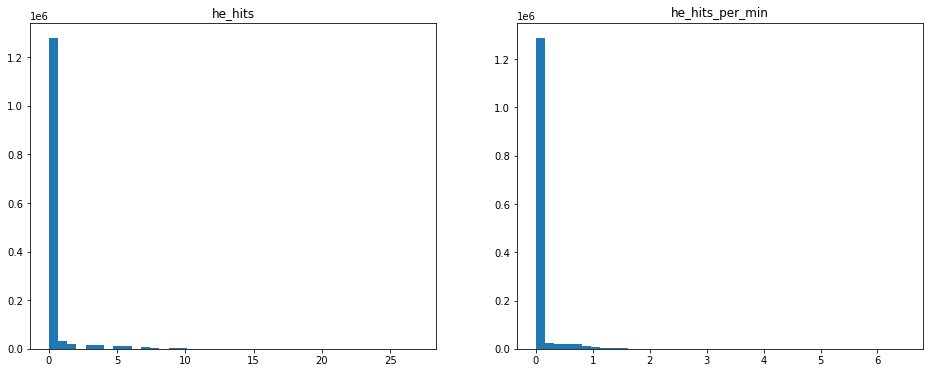

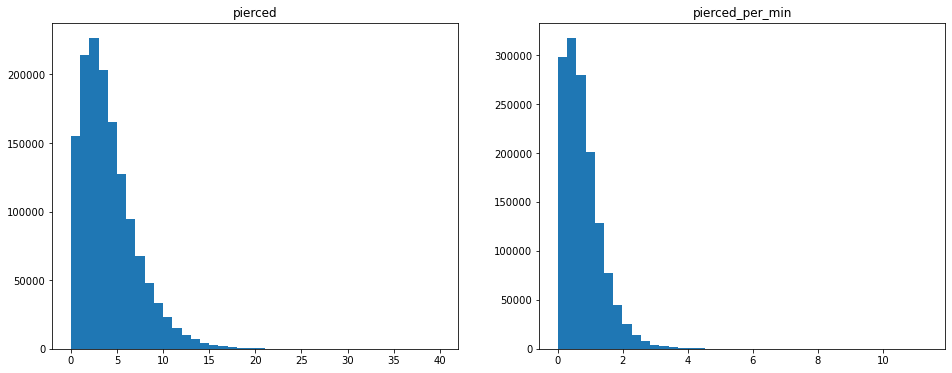

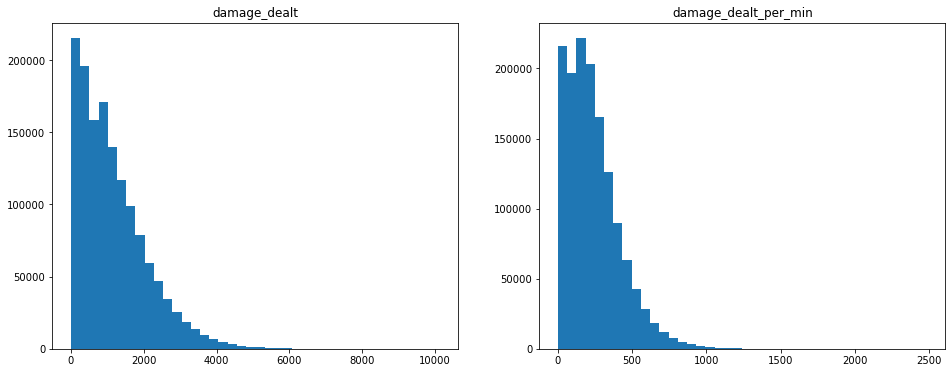

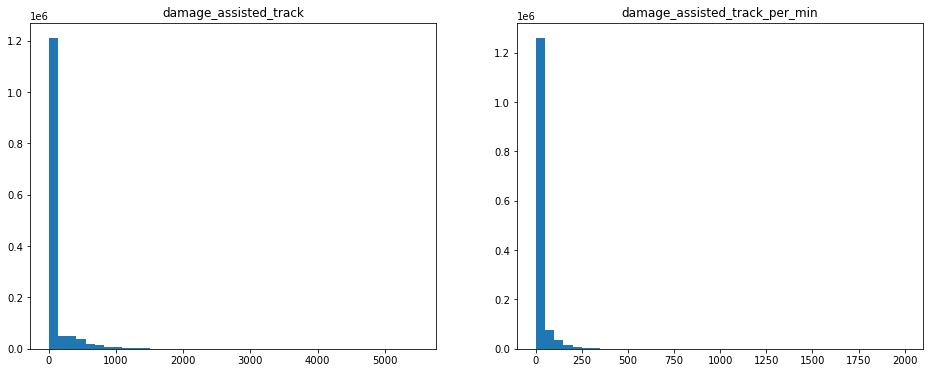

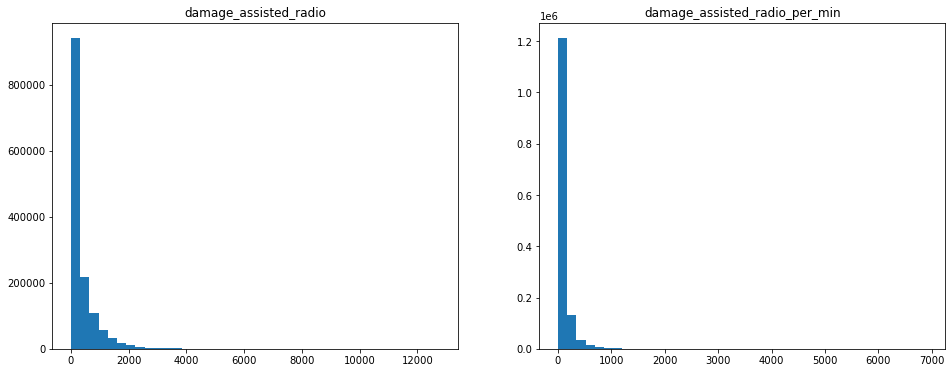

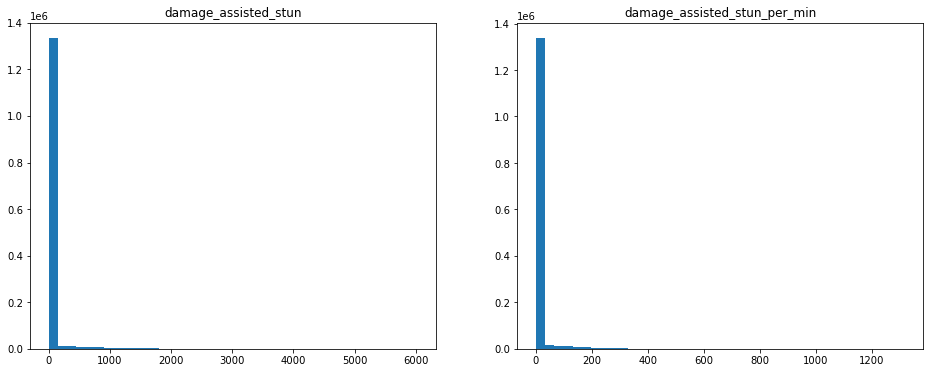

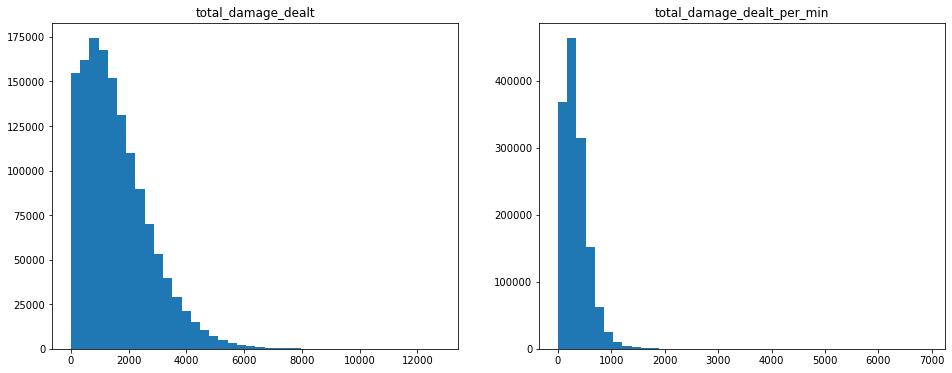

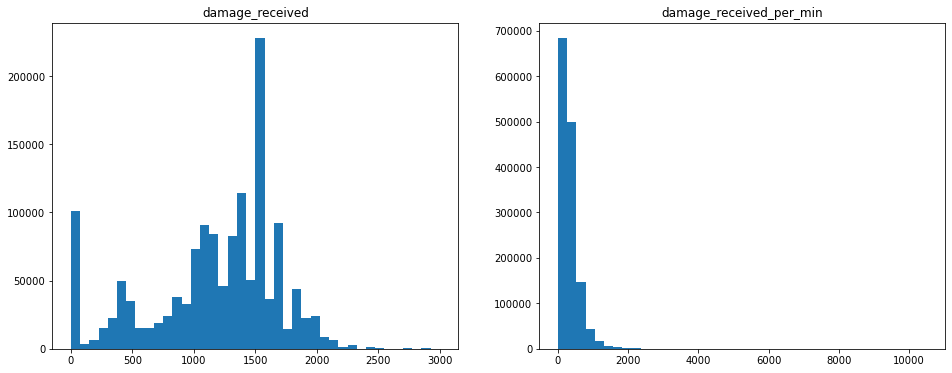

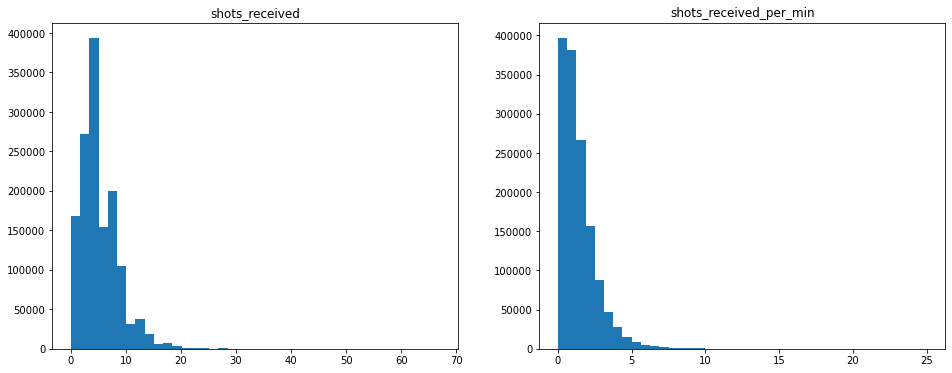

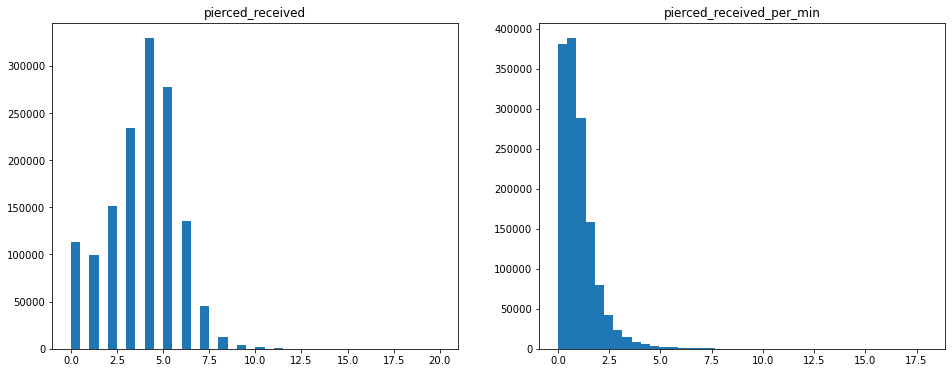

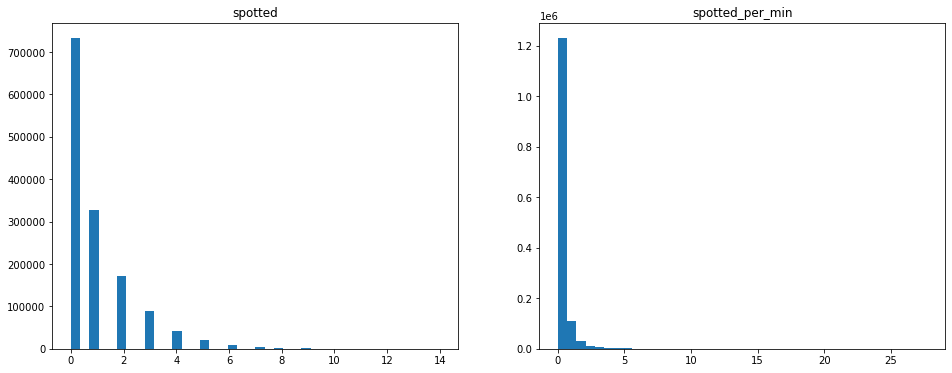

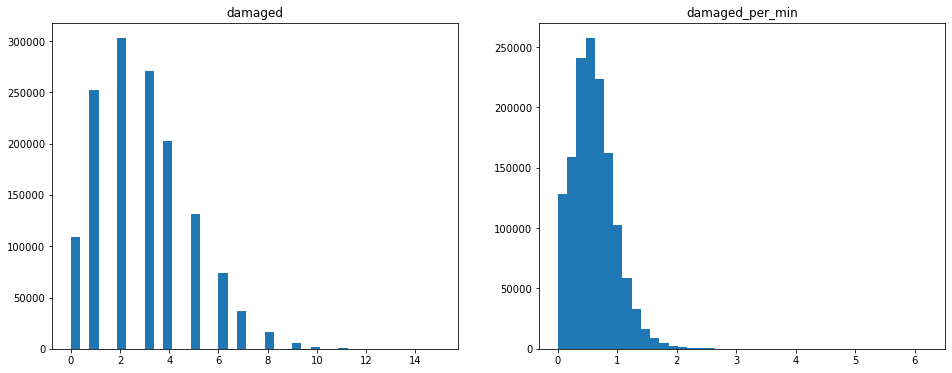

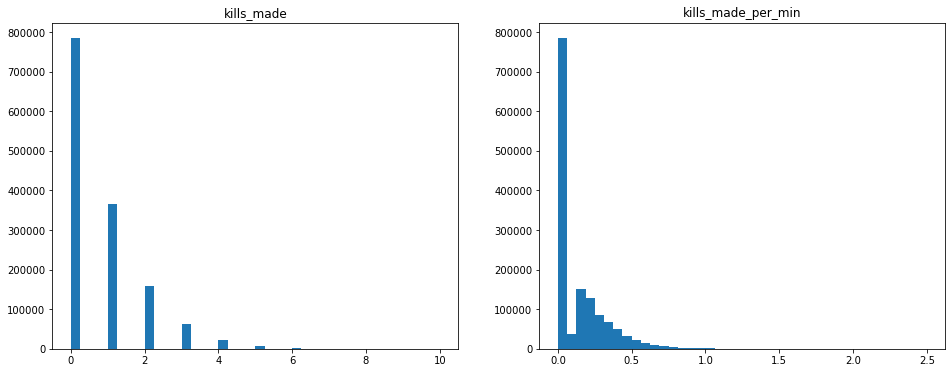

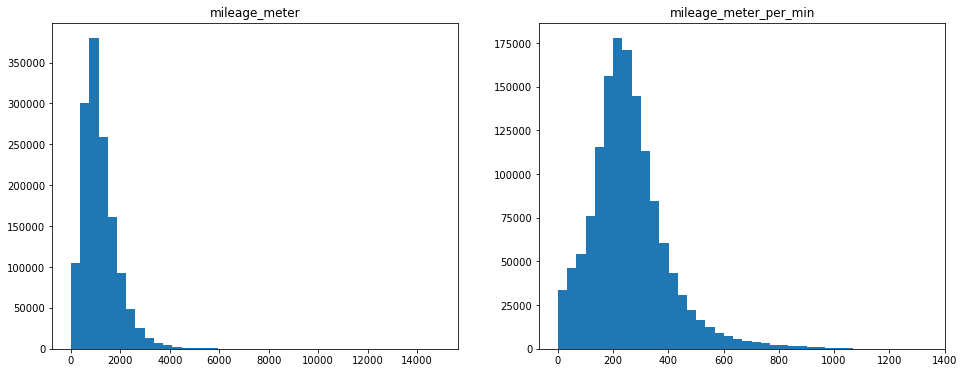

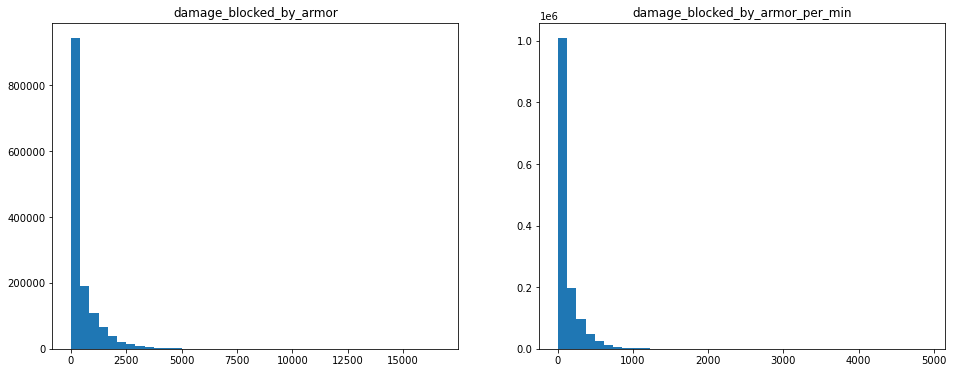

In [67]:
for feature in target_features:
    new_feature = feature + '_per_min'

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].hist(data[feature], bins=40)
    axes[1].hist(data[new_feature], bins=40)
    
    axes[0].set_title(feature)
    axes[1].set_title(new_feature)

### Normalize to hits, shots, etc.

In [68]:
features_normalized = ['hit_rate', 'he_hit_rate', 'pierced_rate',
                      'damage_per_pierced', 'pierced_received_per_shot', 
                      'damage_per_enemy', 'damage_per_enemy_per_min', 
                      'damage_blocked_per_hit', 'damage_blocked_received_ratio']
features_num = ['hits', 'he_hits', 'pierced', 'damage_received', 
               'pierced_received', 'total_damage_dealt', 'total_damage_dealt_per_min', 
               'damage_blocked_by_armor', 'damage_blocked_by_armor']
features_denom = ['shots', 'hits', 'hits', 'pierced_received', 'shots_received', 
                 'damaged', 'damaged', 'pierced_received', 'damage_received']

In [69]:
for new_feature, feature_num, feature_denom in zip(features_normalized,
                                                  features_num, features_denom):
    data[new_feature] = normalize_feature(data[feature_num], data[feature_denom])

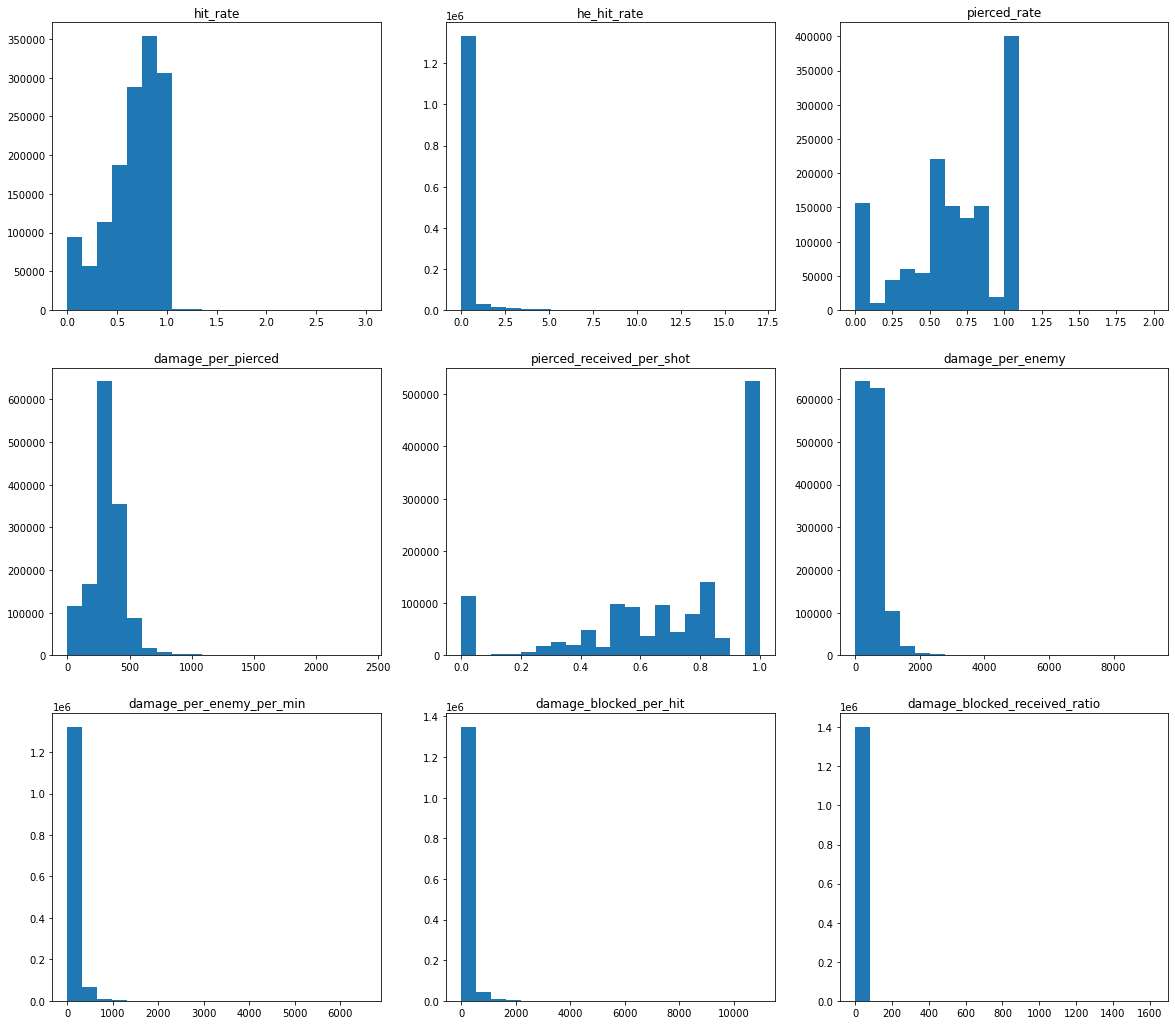

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))
axes = axes.ravel()

for index, feature in enumerate(features_normalized):
    axes[index].hist(data[feature], bins=20);
    axes[index].set_title(feature)

In [71]:
(data['shots_received'] - data['no_damage_shots_received']).min()

0

### Features to be removed from the dataset

In [72]:
redundant_features = ['dt', 'arena_id', 'team_id', 'clan_db_id', 'prebattle_id', 
                     'is_prebattle_creator', 'premium_xp_factor', 
                     'daily_xp_factor', 'battle_num'] + target_features

In [73]:
data.drop(redundant_features, axis=1, inplace=True)

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403405 entries, 0 to 1403404
Data columns (total 36 columns):
account_db_id                      1403405 non-null category
vehicle_type_cd                    1403405 non-null category
life_time_sec                      1403405 non-null int64
no_damage_shots_received           1403405 non-null int64
remained_hp                        1403405 non-null int64
original_credits                   1403405 non-null int64
original_xp                        1403405 non-null int64
booster_bonus_credits              1403405 non-null int64
booster_bonus_xp                   1403405 non-null int64
life_time_min                      1403405 non-null float64
shots_per_min                      1403405 non-null float64
hits_per_min                       1403405 non-null float64
he_hits_per_min                    1403405 non-null float64
pierced_per_min                    1403405 non-null float64
damage_dealt_per_min               1403405 non-null float64

## Examining outliers

### Calculate z-scores for different features

In [75]:
def calculate_z_score(data):
    return stats.zscore(data)

Something does not work here, check later

In [76]:
# features = data.columns.values
# z_scores = np.zeros((data.shape[0], len(features)))
# z_score_threshold = 3

# feature_outliers = dict.fromkeys(features)

# # z-scores for old features
# for index, feature in enumerate(features):
#     feature_outliers = calculate_z_score(data[feature])
    
#     z_scores[:, index] = feature_outliers
#     feature_outliers[feature] = data[feature_outliers > z_score_threshold]
    
#     print(feature, feature_outliers[feature].shape[0])
    
#     # Plotting feature distribution
#     fig, ax = plt.subplots()
#     sns.distplot(data[feature], kde=False);
#     plt.axvline(feature_outliers[feature][feature].min(), ymin=0, ymax=ax.get_ylim()[1])

### Replace values

In [77]:
data.loc[data['hit_rate'] > 1, 'hit_rate'] = 1
data.loc[data['pierced_rate'] > 1, 'pierced_rate'] = 1
data.loc[data['remained_hp'] < 0, 'remained_hp'] = 1

## Merge two dataframes

In [78]:
data_merged = data.merge(catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')

# Build models

In [79]:
tank_classes = data_merged['item_class'].unique()

## Initial checks

### Check how item price in gold depends on the level for different item classes

In [114]:
k = 10
epochs = 100

models = []
for train_index, test_index in KFold(n_splits=k).split(train_data):
    x_train, y_train = train_data[train_index], train_labels[train_index]
    x_test, y_test = train_data[test_index], train_labels[test_index]
    
    model = build_model()
    history = model.fit(x_train, y_train, 
                        validation_data=(x_test, y_test),
                        epochs=epochs, shuffle=True)
    loss = model.evaluate(x_test, y_test)
    models.append((model, history, loss))

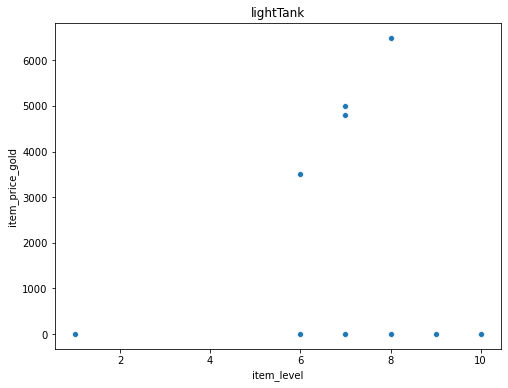

In [126]:
for tank_class in tank_classes:
    class_data = data_merged[data_merged['item_class'] == tank_class]
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(class_data['item_level'], class_data['item_price_gold']);
    plt.title(tank_class)

In [81]:
data_merged_sample = data_merged.sample(n=10_000)

### Check how different characteristics correlate with item level

In [82]:
features = np.setdiff1d(data.columns.values, ['item_price_credit', 'item_price_gold', 'item_level'])

data_sample_ = data_merged_sample[data_merged_sample['item_class'] == 'mediumTank']

for feature in features:
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data_sample_['item_level'], data_sample_[feature]);

### Check how many entries corresponding to every tank we have in the dataset

In [89]:
unique_tanks = data_merged[data_merged['item_price_credit'] > 0]['vehicle_type_cd'].value_counts()
unique_tanks

5377     28554
20481    21367
11521    20124
4353     17621
17473    17554
         ...  
15137       55
11585       27
8497        26
1889        24
9809         6
Name: vehicle_type_cd, Length: 239, dtype: int64

## Create different models

In [308]:
import sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.manifold import TSNE

In [169]:
mean_dataset = data_merged.groupby('vehicle_type_cd').mean()
regression_dataset = mean_dataset[mean_dataset['item_price_gold'] > 0]

regression_target = regression_dataset['item_price_gold']
regression_features = regression_dataset.drop(['item_price_gold', 'item_price_credit', 
                                              'item_cd'], axis=1)

Choose regression features

In [170]:
target_scaled_1 = regression_target / 10_000
target_scaled_2 = StandardScaler().fit_transform(regression_target.values.reshape(-1, 1))
target_scaled_3 = MinMaxScaler().fit_transform(regression_target.values.reshape(-1, 1))

Target distribution has not been changed after scaling

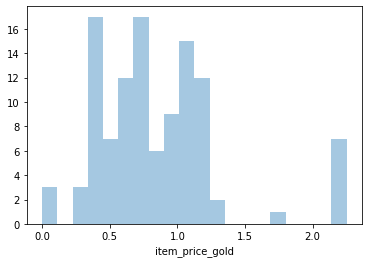

In [171]:
plot_history(models)

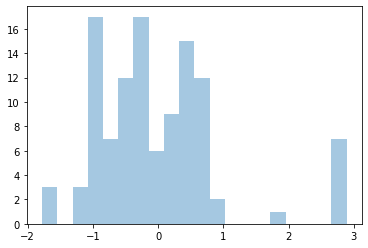

In [127]:
plt.figure();
sns.distplot(target_scaled_1, bins=20, kde=False);

plt.figure();
sns.distplot(target_scaled_2, bins=20, kde=False);

Introducing different regression models

In [200]:
models = [RandomForestRegressor(n_estimators=500, max_depth=4), 
          GradientBoostingRegressor(n_estimators=500, max_depth=4)]
model_names = ['RandomForest', 'GradientBoost']

In [225]:
tt_split = 10

mse_scores = pd.DataFrame(data=np.zeros((tt_split, len(models))),
                          columns=model_names)
r2_scores = pd.DataFrame(data=np.zeros((tt_split, len(models))), 
                         columns=model_names)

regression_results = dict.fromkeys(range(tt_split))

for tt in range(tt_split):
    x_train, x_test, y_train, y_test = train_test_split(regression_features, 
                                                        regression_target, 
                                                        test_size=0.3)
    
    scaler = StandardScaler()
    # Scaling features
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    # Scaling targets
    y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1)).ravel()
    
    results = y_test.values.reshape(-1, 1)
    for idx, model in enumerate(models):
        model.fit(x_train_scaled, y_train_scaled)
        y_predicted = model.predict(x_test_scaled)
        
        # Saving prediction results
        results = np.hstack((results, scaler.inverse_transform(y_predicted).reshape(-1, 1)))
    
        # Saving accuracy scores
        mse_scores.iloc[tt, idx] = mean_squared_error(y_test_scaled, y_predicted)
        r2_scores.iloc[tt, idx] = r2_score(y_test, y_predicted)
    
    # Saving prediction results
    regression_results[tt] = pd.DataFrame(data=results, index=x_test.index.values,
                                          columns=['y'] + model_names)

In [338]:
def compare_results(targets, model_name):
    # Compare target and predicted values
    target = targets[0]
    predicted = targets[1]
    
    plt.figure(figsize=(10, 6));
    sns.regplot(x=target, y=predicted, marker="*", scatter_kws={"s": 80}, ci=68);
    plt.xlabel('Target price');
    plt.ylabel('Predicted price');
    plt.title('Predicted vs. target - ' + model_name)
    
    
def visualize_data(pca_data, targets, model_name, dr_type):
    
    # Visualize first PCs
    fig, axes = plt.subplots(1, 2, figsize=(18, 6));
    
    for idx, axis in enumerate(axes):
        sns.scatterplot(pca_data[:, 0], pca_data[:, 1],
                        marker="o", hue=targets[idx], s=100, ax=axis);
        axis.set_xlabel(dr_type + ' 1');
        axis.set_ylabel(dr_type + ' 2');
        axis.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False);
        if idx == 0:
            axis.set_title(dr_type + ' scores - target prices')
        else:
            axis.set_title(dr_type + ' scores - predicted prices, ' + model_name)
    
    
def perform_pca(data):
    # Scale data and perform PCA
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
    pca_model = PCA(n_components=0.95)
    data_pca = pca_model.fit_transform(data_scaled)
    return data_pca

Visualize best predictions

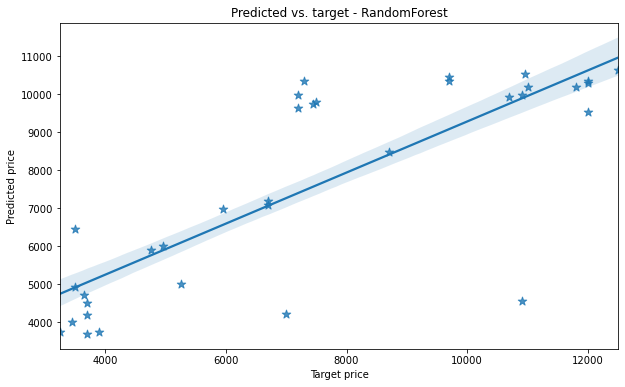

In [339]:
mean_mse = get_mean_mse(models)
mean_mse

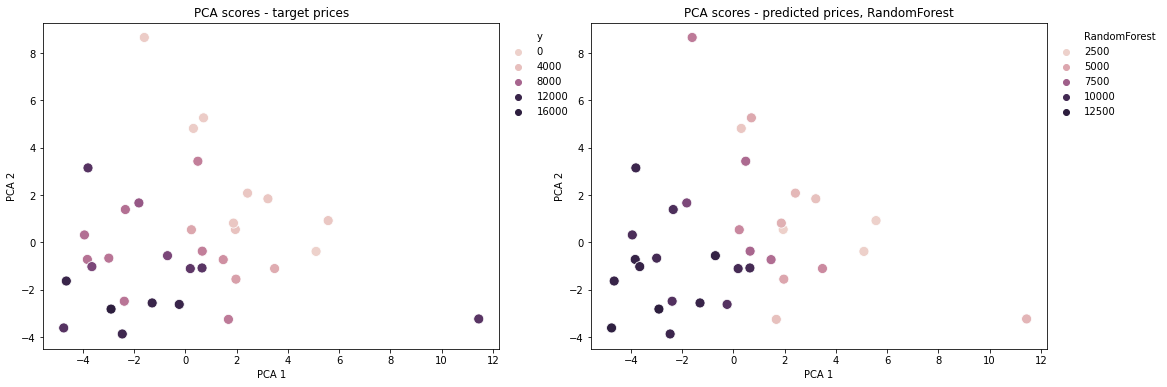

In [129]:
#'item_level', 'item_class' 'damage_dealt', 'original_xp', 'original_credits', 'kills_made', 'damage_assisted_stun', 'he_hits', 'crew_size', 'hits', 'booster_bonus_credits'

tank_params = [[8, 2, 994.758446, 1051.125426, 41486.045662, 0.614389, 0.0, 0.054945, 4.0, 5.207303, 2978.862081, 5]]

best_model = get_best_model(models)

x = gold_scaler.transform(tank_params)[:,:len(tank_params[0])-1]
test_predictions = models[ind][0].predict(x)
xx = np.concatenate((x[0], test_predictions[0]))
gold_scaler.inverse_transform(xx)[-1]

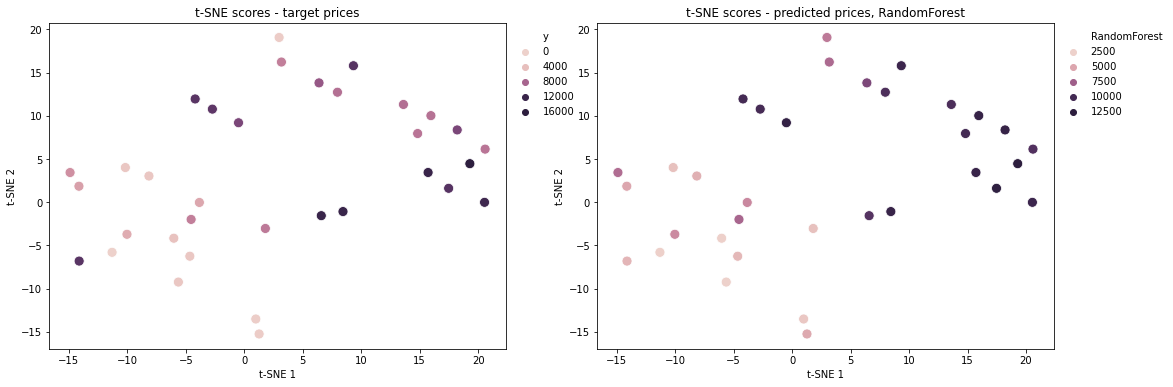

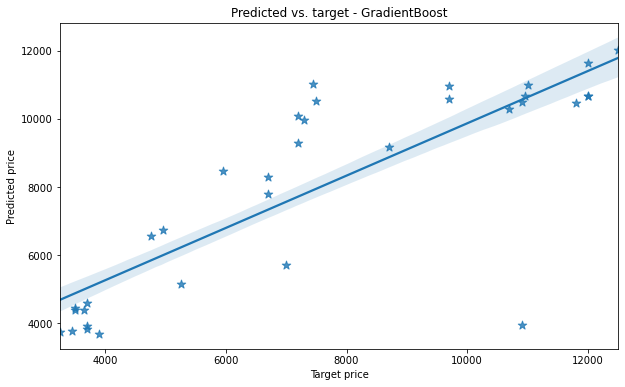

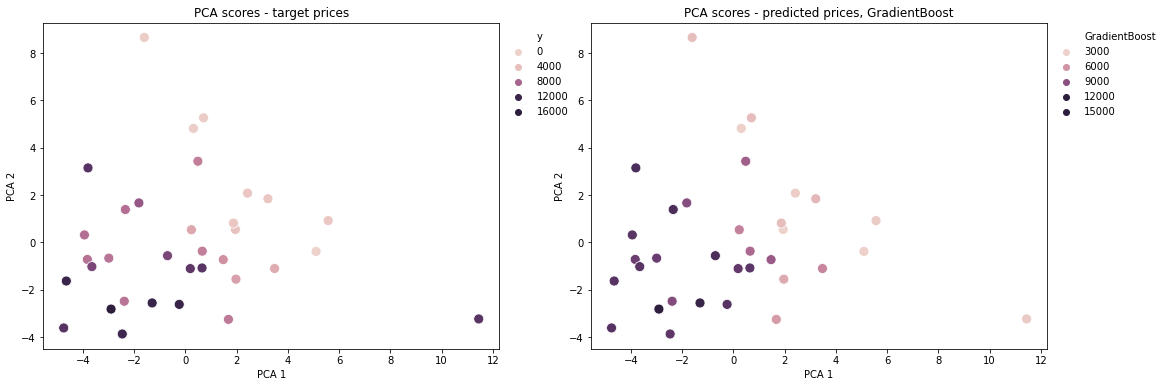

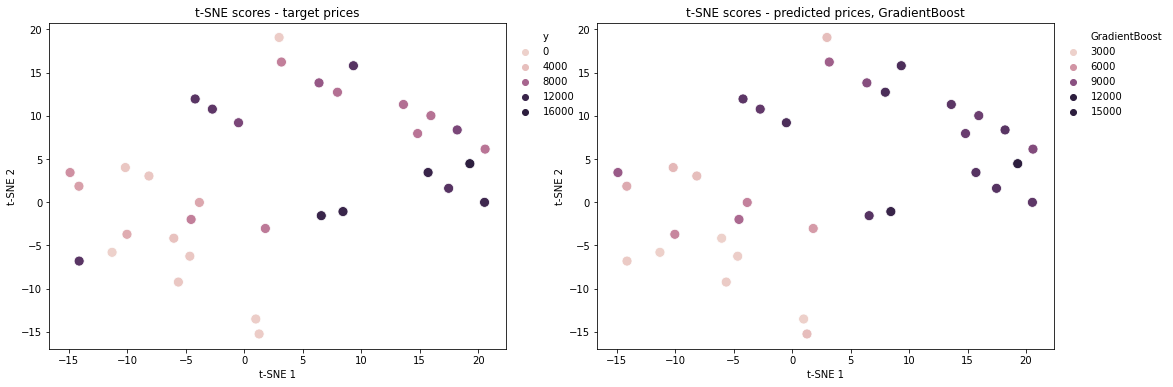

In [110]:
for model in model_names:
    best_prediction = mse_scores[model].idxmin()

    targets = [regression_results[best_prediction]['y'],
               regression_results[best_prediction][model]]

    compare_results(targets, model)
    
    # Perform PCA and visualize results
    items = regression_features.loc[regression_results[best_prediction][model].index]
    pca_items = perform_pca(items)

    visualize_data(pca_items, targets, model, dr_type='PCA')
    
    # Perform TSNE and visualize results
    tsne_items = TSNE(n_components=2, perplexity=5, learning_rate=10, init='pca').fit_transform(pca_items)
    
    visualize_data(tsne_items, targets, model, dr_type='t-SNE')

### Use Sequential Feature Selection (with Random Forest)

In [ ]:
res_data[res_data['vehicle_type_cd'] == 9217][features]

In [ ]:
tt_split = 10

mse_scores = np.zeros((tt_split, 2))

for tt in range(tt_split):
    x_train, x_test, y_train, y_test = train_test_split(regression_features, 
                                                        regression_target, 
                                                        test_size=0.3)
    
    scaler = StandardScaler()
    # Scaling features
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    # Scaling targets
    y_train_scaled = scaler.fit_transform(y_train)
    y_test_scaled = scaler.transform(y_test)
    
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=2, 
                                     random_state=0, n_jobs=8)
    
    feature_selector = SFS(rf_model, 
                           k_features=(2, 10), 
                           forward=True, 
                           floating=False, 
                           verbose=2,
                           scoring='neg_mean_squared_error',
                           n_jobs=2,
                           cv=0)
    
    x_train_selected = feature_selector.fit_transform(x_train_scaled, 
                                                      y_train_scaled)
    x_test_selected = feature_selector.transform(x_test_scaled)
    
    rf_model.fit(x_train_selected, y_train_scaled)
    y_predicted = rf_model.predict(x_test_selected)
    
    mse_scores[tt, 0] = mean_squared_error(y_test_scaled, y_predicted)
    mse_scores[tt, 1] = r2_score(y_test, y_predicted)